In [1]:
import os
import glob

import tables as tb
import numpy  as np
import pandas as pd

from collections import defaultdict

In [2]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook
%matplotlib inline
### Useful parameters for plots
mpl.rcParams["figure.figsize"]          = 12,10
mpl.rcParams["font.size"]               = 20
mpl.rcParams["figure.max_open_warning"] = 100
mpl.rcParams["font.size"]               = 20
mpl.rcParams["font.weight"]             ='normal'
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['axes.facecolor'] = 'w'
mpl.rcParams['figure.facecolor'] = 'w';

In [3]:
import invisible_cities.io.pmaps_io as pmapio
import invisible_cities.io.dst_io  as dstio
import invisible_cities.io.mcinfo_io as mcio
import gres.database.load_db as db
import invisible_cities.io.run_and_event_io as rio

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions as fitf

from lmfit.models import GaussianModel

In [4]:
nfiles = 100000
datatypes = ['22Na', '83mKr', '133Ba', 'NoSource', '57Co', '241Am', '55Fe', 'LED']#[2]

### Read data

In [93]:
run_numbers = [78, 79, 80]  # Thr at -50
run_numbers = [76, 77]  # Thr at -80
# run_numbers = [66, 71, 72, 75] # Thr at -20
run_numbers = [106]  # Thr at -20
# run_numbers = [123] # Thr at -20
run_numbers = [131, 132, 133]  # Thr at -20
# run_numbers = [133] # Thr at -20
#run_numbers = [139, 140]
run_numbers = [219, 220]  # Thr at -20
run_numbers = [777, 826, 866]  # Thr at -20
run_numbers = [777, 776]  # Thr at -20
# run_numbers = [577] # Thr at -20
#run_numbers = [147, 148, 149]

source = datatypes[6]
#inpath = f'/home/ander/Work/GaP/real_data/Na22/R{run_number}/octavia/'

data_1_s1 = []
data_1_s2 = []


for run_number in run_numbers:
    inpath = f'/home/ander/Work/GaP/real_data/{source}/R{run_number}/octavia/'
    data_1_s1.append(pd.read_hdf(
        inpath+f'DST_run_{run_number}_pmaps.h5', 'S1'))
    data_1_s2.append(pd.read_hdf(
        inpath+f'DST_run_{run_number}_pmaps.h5', 'WVF'))
#    data_1_s2.append(pd.read_hdf(inpath+f'DST_run_{run_number}_pmaps.h5', 'WVF'))

data_1_s1 = pd.concat(data_1_s1).reset_index(drop=True)
data_1_s2 = pd.concat(data_1_s2).reset_index(drop=True)

data_1_s1['r'] = np.sqrt(data_1_s1.x**2 + data_1_s1.y**2)
data_1_s2['r'] = np.sqrt(data_1_s2.x**2 + data_1_s2.y**2)

if 's1_t' in data_1_s2.columns:
    data_1_s2['sub_energy'] = data_1_s2['energy'] - 558#data_1_s2['s1_energy']


label_1 = 'High drift'  # source

weights_1_s1 = np.ones(len(data_1_s1))
weights_1_s2 = np.ones(len(data_1_s2))

### Look at data

2501.0


Text(0.55, 618.45, 'Background induced threshold')

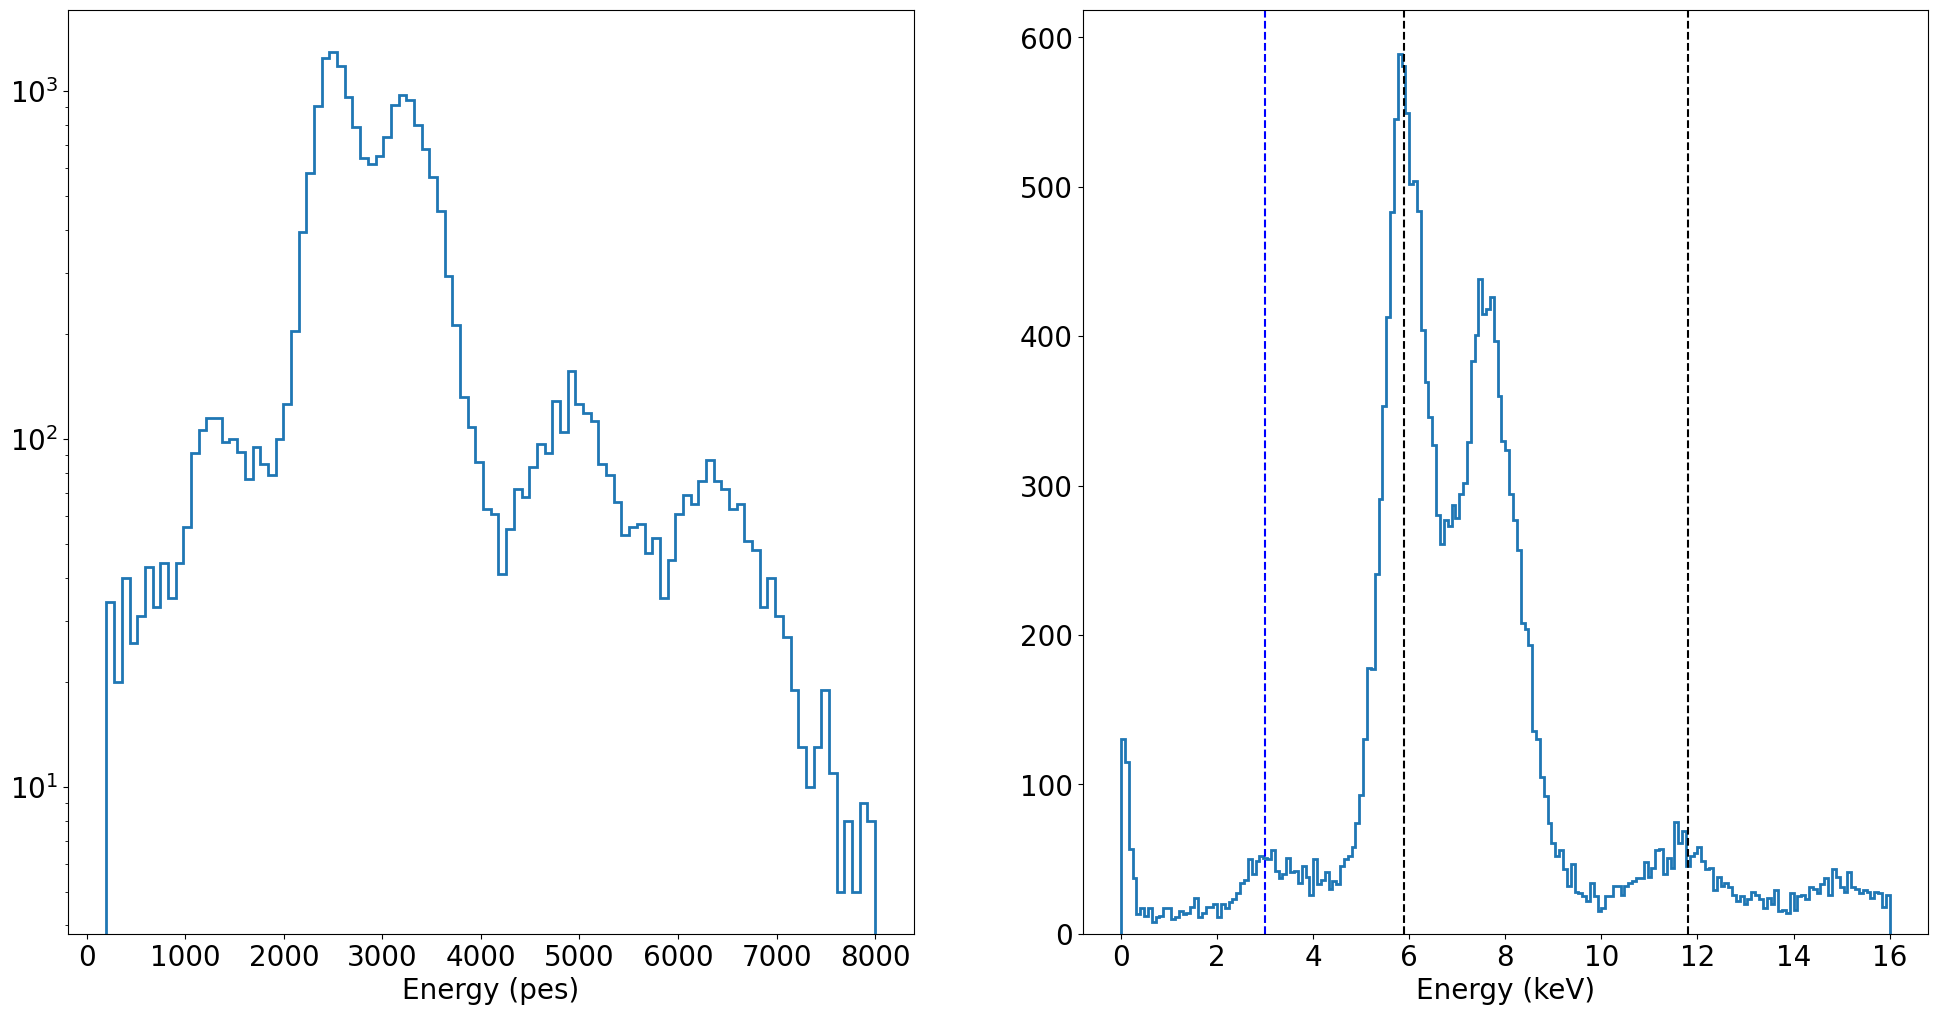

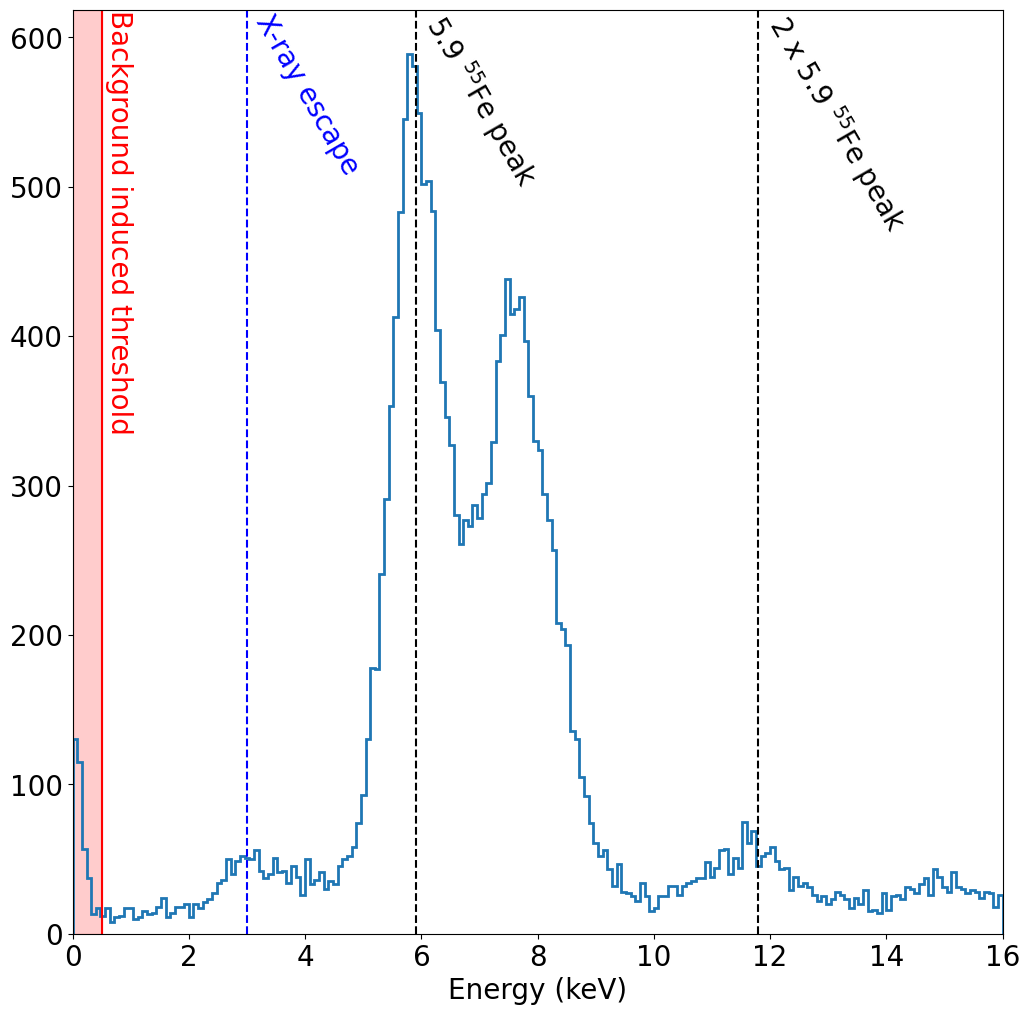

In [94]:
fig, axes  = plt.subplots(1, 2, figsize=(24, 12))
fig, axes2 = plt.subplots(1, 1, figsize=(12, 12))

enebins = np.linspace(200, 8000, 101)
#enebins = np.linspace(50000, 200000, 201)
enebins_c = np.linspace(0.,16, 201)
normed = False
var    = 'energy'
#var    = 'e_pmt0_s1'
#var    = 'ped_sum_pmt1'
#var    = 'e_pmt0'

eref = 5.9
#eref = 0.3
#eref = 5.9

y,x, *_ = axes[0].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);
x = coref.shift_to_bin_centers(x)
escale_1 = x[y.argmax()]/eref
print(x[y.argmax()])
#escale_1 = 375/eref
#enebins = np.linspace(0.01, 2, 51)
axes[1].hist(data_1_s2[var]/escale_1, enebins_c, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);
axes2.hist(data_1_s2[var]/escale_1, enebins_c, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);

for ax in axes:
    #ax.set_yscale('log')
    pass

axes[0].set_xlabel('Energy (pes)')
axes[1].set_xlabel('Energy (keV)')
axes2.set_xlabel('Energy (keV)')

ar_xray   = [5.9-2.9, 3.2][:1]
colors    = ['b'] * len(ar_xray)
#al_xray   = [1.5]
#colors   += ['k'] * fe_lines
fe_lines  = [5.9, 6.5]
fe_lines  = [5.9]
fe_lines  = [feline*i for feline in fe_lines for i in range(1, 3)]
colors   += ['k'] * len(fe_lines)
kr_line   = [41.5]
colors   += ['g'] * len(fe_lines)
#cu_lines = [9.4]
#colors   += ['r'] * len(cu_lines)
#
#am_lines = [13.9, 17.7, 26.3, 59.6][:2] # From 2212.11515
#colors   += ['g'] * len(am_lines)
energy_lines = ar_xray  + fe_lines #+kr_line#+  am_lines
texts = ['X-ray escape', r'5.9 $^{55}$Fe peak', r'2 x 5.9 $^{55}$Fe peak']
for color, line, text in zip(colors, energy_lines, texts):
    axes[1].axvline(line, c=color, ls='--')
    axes2.axvline(line, c=color, ls='--')
    axes2.text(x=line+0.05, y=axes2.get_ylim()[1], s=text, c=color, verticalalignment='top', rotation=300)
    pass
erange = [2300, 5000]
erange = [800, 1600]
erange = [400, 600]
erange = [6000, 11000]
#axes[0].axvspan(*erange, alpha=0.2)
erange = [30, 50]
#axes[1].axvspan(*erange, alpha=0.2)
sel_e_1 = coref.in_range(data_1_s2[var]/escale_1, *erange)



#mcpath = f'/home/ander/Work/GaP/nexus_quick_sim/data/SummaryDST_55Fe_{pressure}bar.h5'
#
#mc_dst = pd.read_hdf(mcpath)
axes[0].set_yscale('log')
axes2.axvspan(0, 0.5, color='r', alpha=0.2)
axes2.axvline(0.5, c='r')
axes2.set_xlim(0, 16)

axes2.text(x=0.5+0.05, y=axes2.get_ylim()[1], s='Background induced threshold', c='r', verticalalignment='top', rotation=270)
#axes2.save
#axes[1].set_xlim(0,1)

In [95]:
from lmfit.models import GaussianModel, LinearModel, ExponentialModel, ConstantModel

In [96]:
run_numbers

[777, 776]

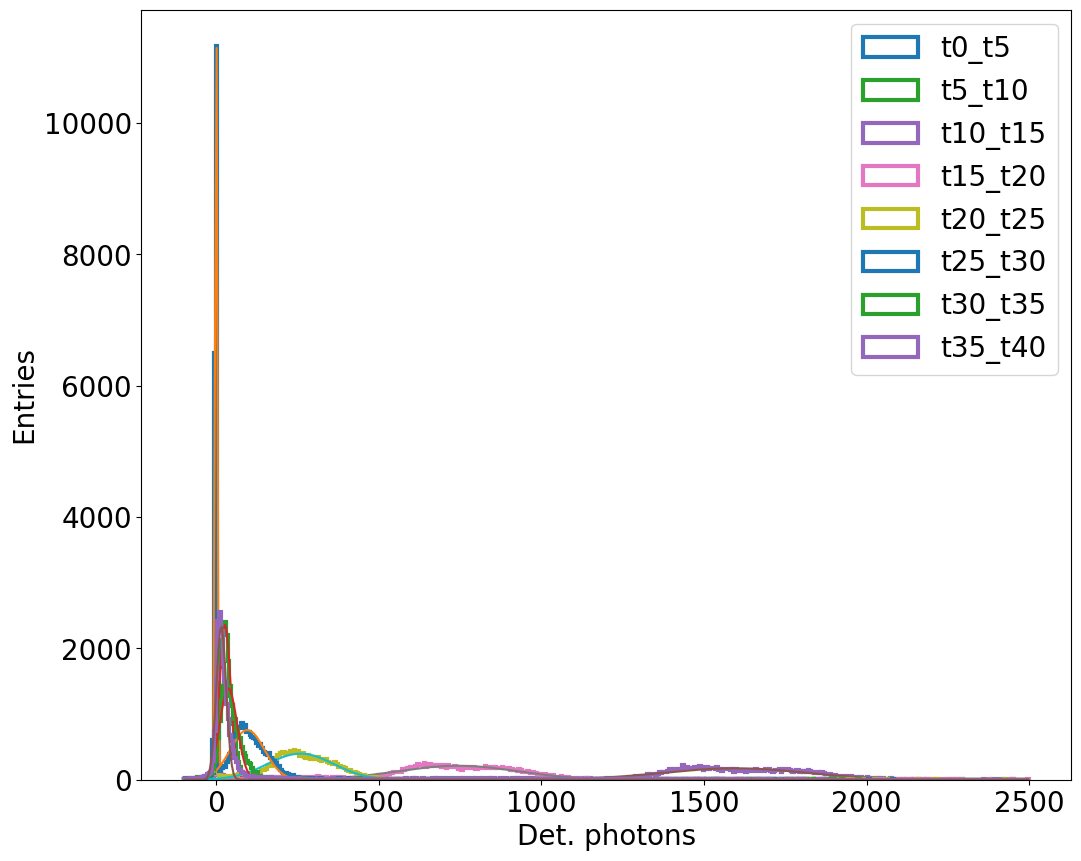

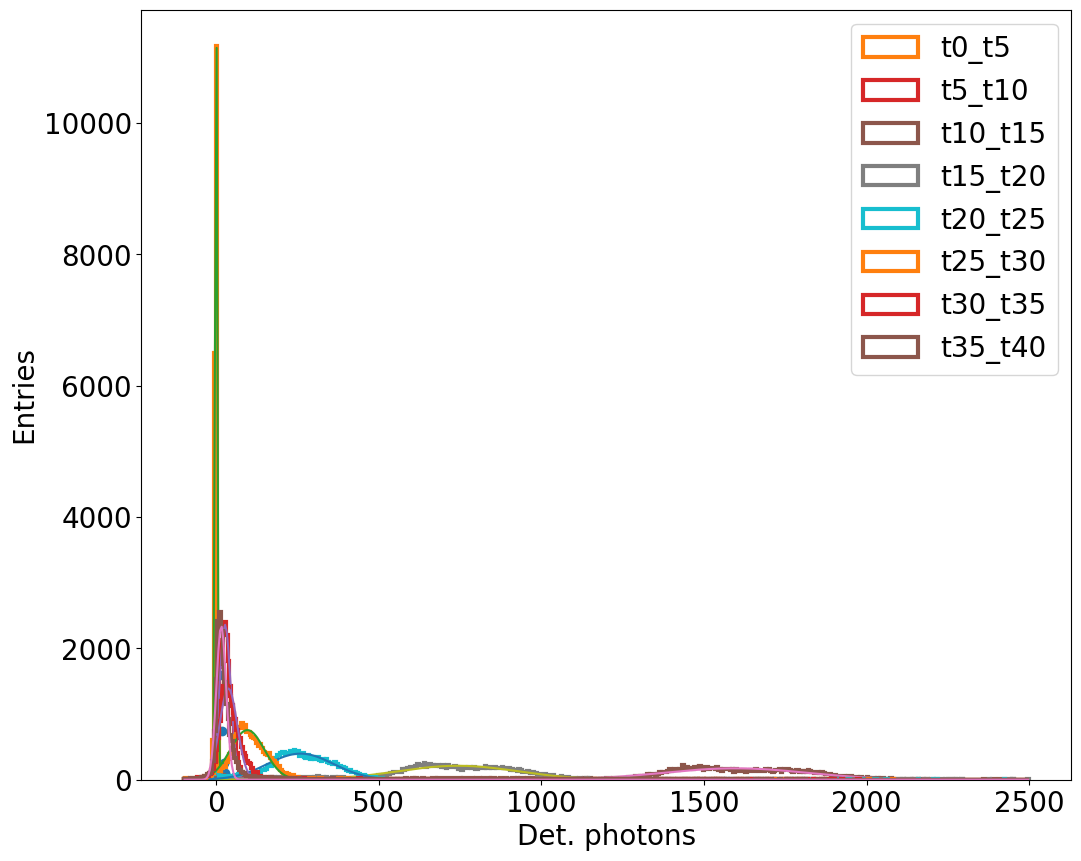

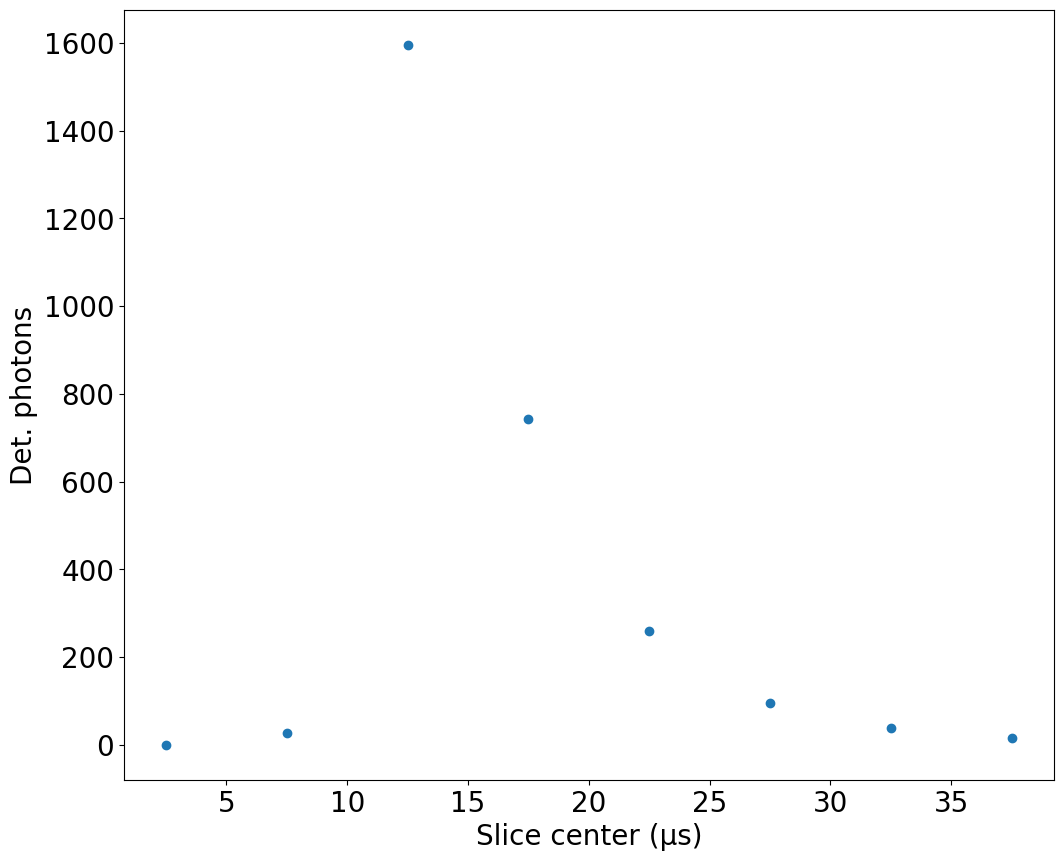

In [97]:
ebins = np.linspace(-0.1e3, 2.5e3, 501)

for run in run_numbers:
    means = []
    plt.figure
    for i, j in zip(range(0, 40,5), range(5,41,5)):
        y, x, *_ = plt.hist(data_1_s2[f'energy_t{i}_t{j}'], ebins, histtype='step', label=f't{i}_t{j}', lw=3)
        x = coref.shift_to_bin_centers(x)
        mod = GaussianModel()
        params = mod.guess(y, x=x)
        res = mod.fit(y, params, x=x)
        plt.plot(x, res.best_fit)
        means.append(res.params['center'].value)
        #means.append(data_1_s2[f'energy_t{i}_t{j}'].mean())
        #plt.axvline(means[-1])
    plt.legend()
    #plt.xscale('log')
    #plt.xlim(-500, 500)
    plt.xlabel('Det. photons')
    plt.ylabel('Entries')
    
    plt.figure()
    plt.plot(coref.shift_to_bin_centers(range(0, 41,5)), means, marker='o', ls='')
    plt.xlabel('Slice center (µs)')
    plt.ylabel('Det. photons')

In [98]:
res.params

name,value,standard error,relative error,initial value,min,max,vary,expression
amplitude,87908.1233,1056.11445,(1.20%),99294.00000000003,-inf,inf,True,
center,15.5553546,0.20789703,(1.34%),14.400000000000006,-inf,inf,True,
sigma,14.9867422,0.20789707,(1.39%),13.000000000000004,0.00000000,inf,True,
fwhm,35.2910803,0.48956018,(1.39%),30.61266000000001,-inf,inf,False,2.3548200*sigma
height,2340.08622,28.1129895,(1.20%),3047.1212874000003,-inf,inf,False,"0.3989423*amplitude/max(1e-15, sigma)"


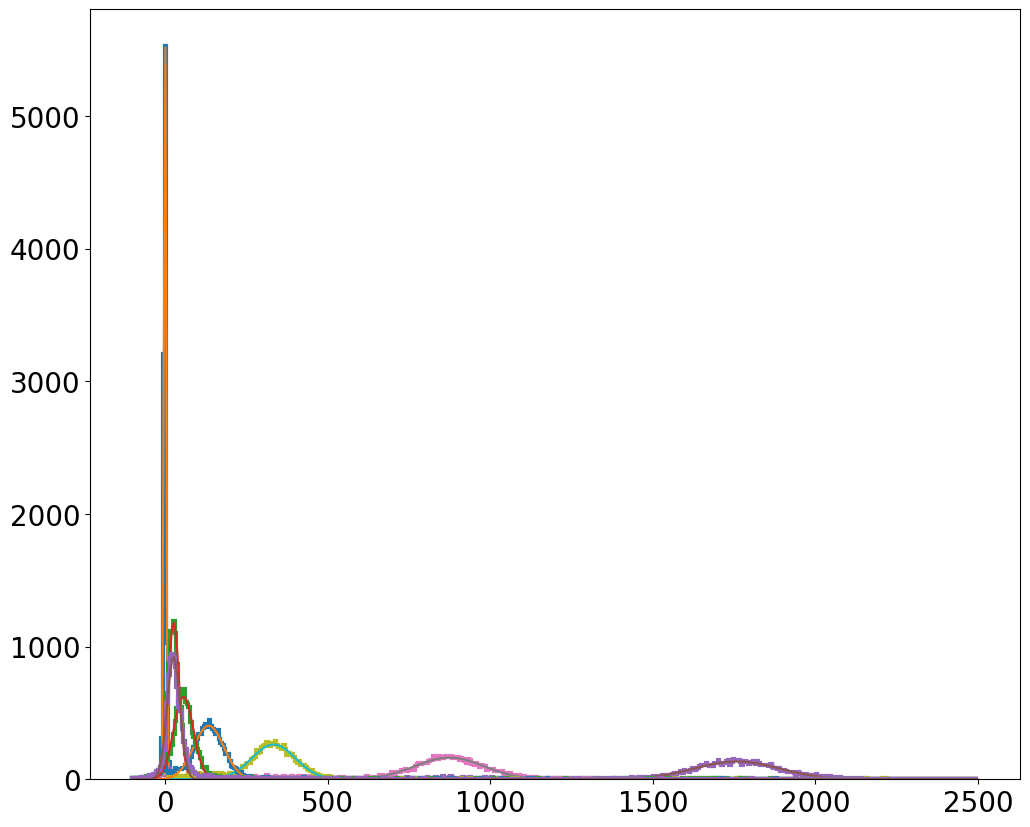

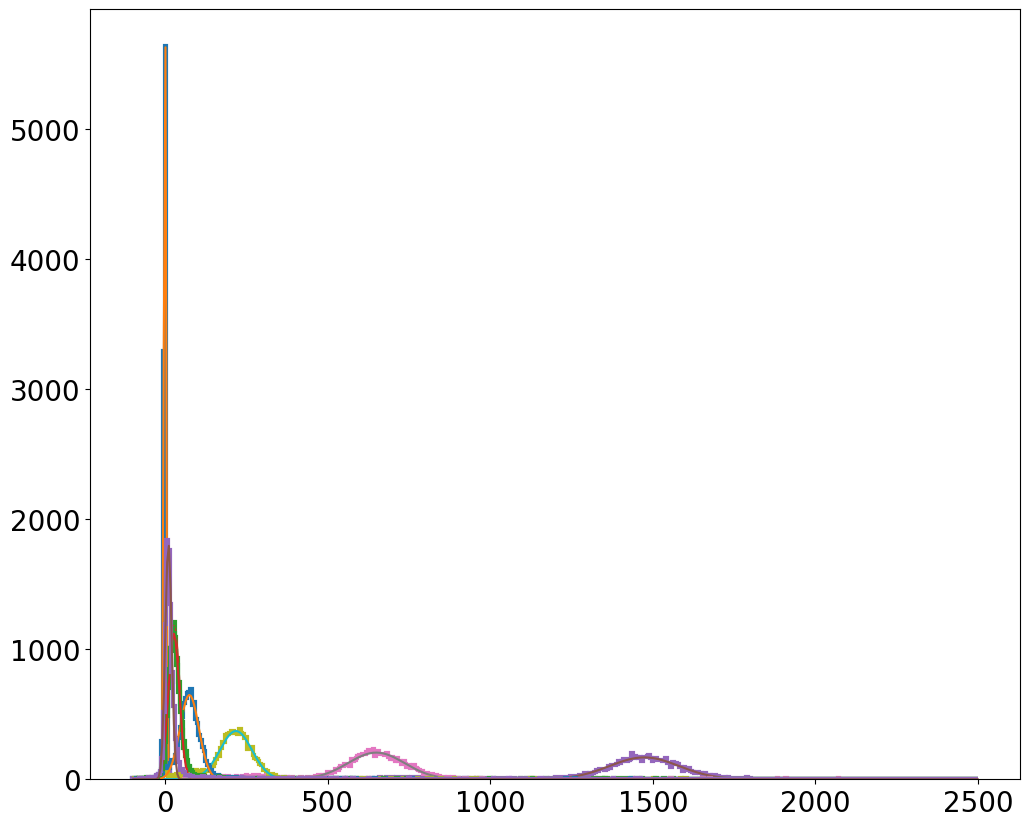

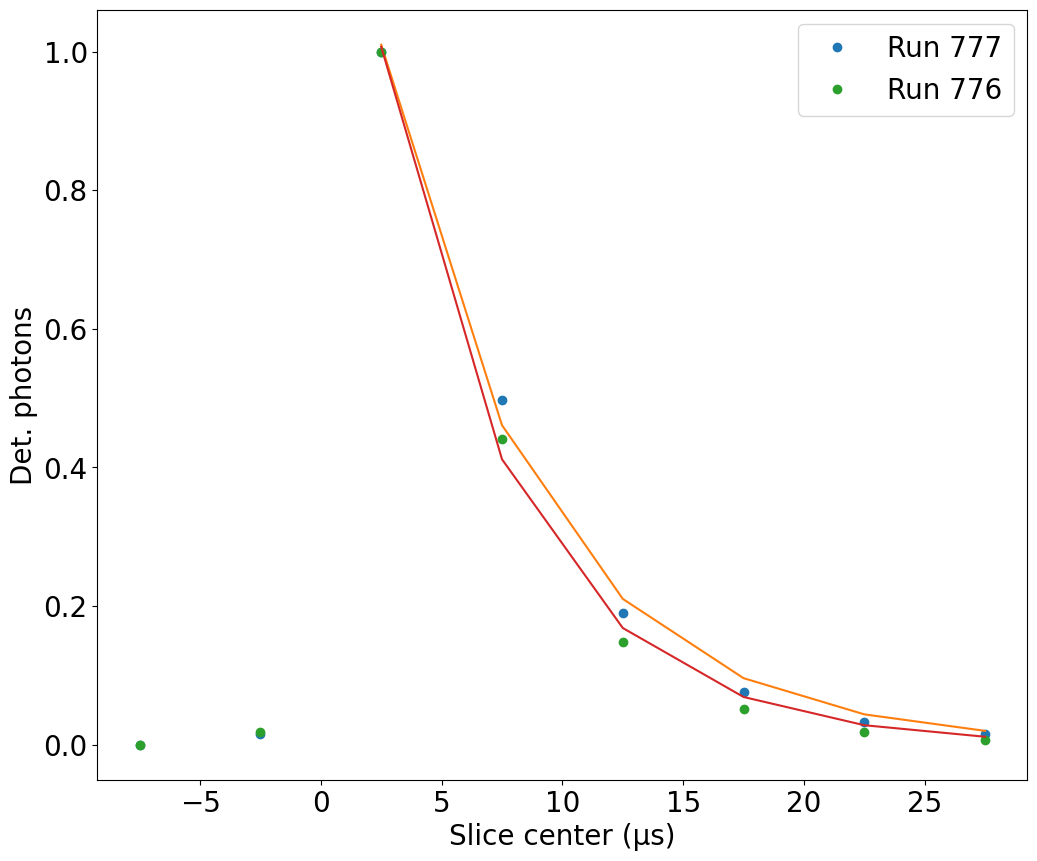

In [99]:
ebins = np.linspace(-0.1e3, 2.5e3, 501)

means_all = {}
for run in run_numbers:
    means = []
    plt.figure()
    dataset = data_1_s2[[str(run) in val for val in data_1_s2.file.values]]
    for i, j in zip(range(0, 40,5), range(5,41,5)):
        y, x, *_ = plt.hist(dataset[f'energy_t{i}_t{j}'], ebins, histtype='step', label=f't{i}_t{j}', lw=3)
        x = coref.shift_to_bin_centers(x)
        mod = GaussianModel()
        params = mod.guess(y, x=x)
        res = mod.fit(y, params, x=x)
        plt.plot(x, res.best_fit)
        means.append(res.params['center'].value)
        #means.append(data_1_s2[f'energy_t{i}_t{j}'].mean())
        #plt.axvline(means[-1])
    means_all[run] = np.array(means)

plt.figure()
decays = []
for run in run_numbers:
    xdata = coref.shift_to_bin_centers(range(0, 41,5))
    xdata = coref.shift_to_bin_centers(range(0-10, 41-10,5))
    ydata = means_all[run]/means_all[run][2]
    plt.plot(xdata, means_all[run]/means_all[run][2], marker='o', ls='', label=f'Run {run}')
    #xdata = coref.shift_to_bin_centers(range(0-10, 41-10,5))
    sel = xdata>=0
    mod = ExponentialModel()
    params = mod.guess(ydata[sel], x=xdata[sel])
    res = mod.fit(ydata[sel], params, x=xdata[sel])
    decays.append(res.params['decay'].value)
    plt.plot(xdata[sel], res.best_fit)
plt.xlabel('Slice center (µs)')
plt.ylabel('Det. photons')
plt.legend()
decays = np.array(decays)

In [100]:
decays

array([6.37476709, 5.5920361 ])

In [55]:
np.in1d('777', data_1_s2.file.values[0])

array([False])

In [67]:
[str(run) in val for val in data_1_s2.file.values]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [43]:
data_1_s2

,event,timestamp,x,y,r,energy,height,ped_sum,e0,s1_energy,...,energy_t0_t5,energy_t5_t10,energy_t10_t15,energy_t15_t20,energy_t20_t25,energy_t25_t30,energy_t30_t35,energy_t35_t40,file,sub_energy
0,0,115,10.641234,-12.145847,16.147986,-1573.019043,5.919055,5.329071e-15,-0.820953,-320.586289,...,-188.330020,-444.554360,468.138301,545.187335,-218.851841,-482.175704,-590.305250,-662.127504,Run_777_file_0_raw.h5,-2131.019043
1,75,29194,-0.795843,-1.443136,1.648031,3344.725768,10.295821,7.216450e-16,-0.045024,3261.389245,...,-3.807596,3.523479,1873.033609,920.462362,349.541603,118.635788,46.453401,36.883121,Run_777_file_0_raw.h5,2786.725768
2,139,37901,14.122320,22.798304,26.817953,-78.527935,1.674290,3.552714e-15,0.084642,-63.881062,...,-5.885112,-10.738695,-9.001855,-15.471355,-12.855224,-9.928820,-13.484210,-1.162663,Run_777_file_0_raw.h5,-636.527935
3,140,83582,1.507347,-3.528505,3.836984,6092.205170,8.223906,0.000000e+00,0.349813,3440.577135,...,0.657786,15.793420,1857.376415,1004.611699,379.560415,182.577399,1502.142682,1149.485354,Run_777_file_0_raw.h5,5534.205170
4,289,170503,1.314864,-2.562018,2.879722,5985.113898,7.531287,-6.661338e-16,-0.129132,5772.692387,...,-4.674659,14.431161,1684.204229,2278.545176,1318.937552,481.248927,158.778392,53.643119,Run_777_file_0_raw.h5,5427.113898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11889,8203177,34356110787,1.370347,-2.604832,2.943298,1325.154564,4.227260,-4.440892e-16,-0.053241,1294.043684,...,-6.695658,18.612919,711.835168,372.640844,144.364293,53.286117,22.870762,8.240118,Run_777_file_9_raw.h5,767.154564
11890,8203408,34356163733,1.034119,-1.213460,1.594330,3544.722355,6.614069,-9.714451e-16,0.125207,3448.947897,...,0.741476,31.127578,1895.456227,992.514369,398.280934,130.827313,56.390409,39.384050,Run_777_file_9_raw.h5,2986.722355
11891,8203599,34356375453,1.910077,-2.216261,2.925783,3483.413618,11.824568,-8.881784e-16,0.151004,3415.441801,...,0.091964,30.581811,1927.221713,934.070292,388.278894,135.197127,42.459957,25.511861,Run_777_file_9_raw.h5,2925.413618
11892,8203672,34356410007,0.280366,-2.272788,2.290015,3089.324759,7.333681,0.000000e+00,0.031808,3015.790149,...,-2.122020,12.670754,1667.241071,903.752182,313.905092,120.343069,60.050510,13.484101,Run_777_file_9_raw.h5,2531.324759


In [16]:
2510/8.83/5.9

48.17935773652993

In [23]:
43508.25*59.4/5448

474.3740914096916

35625.0


(0.0, 1.0)

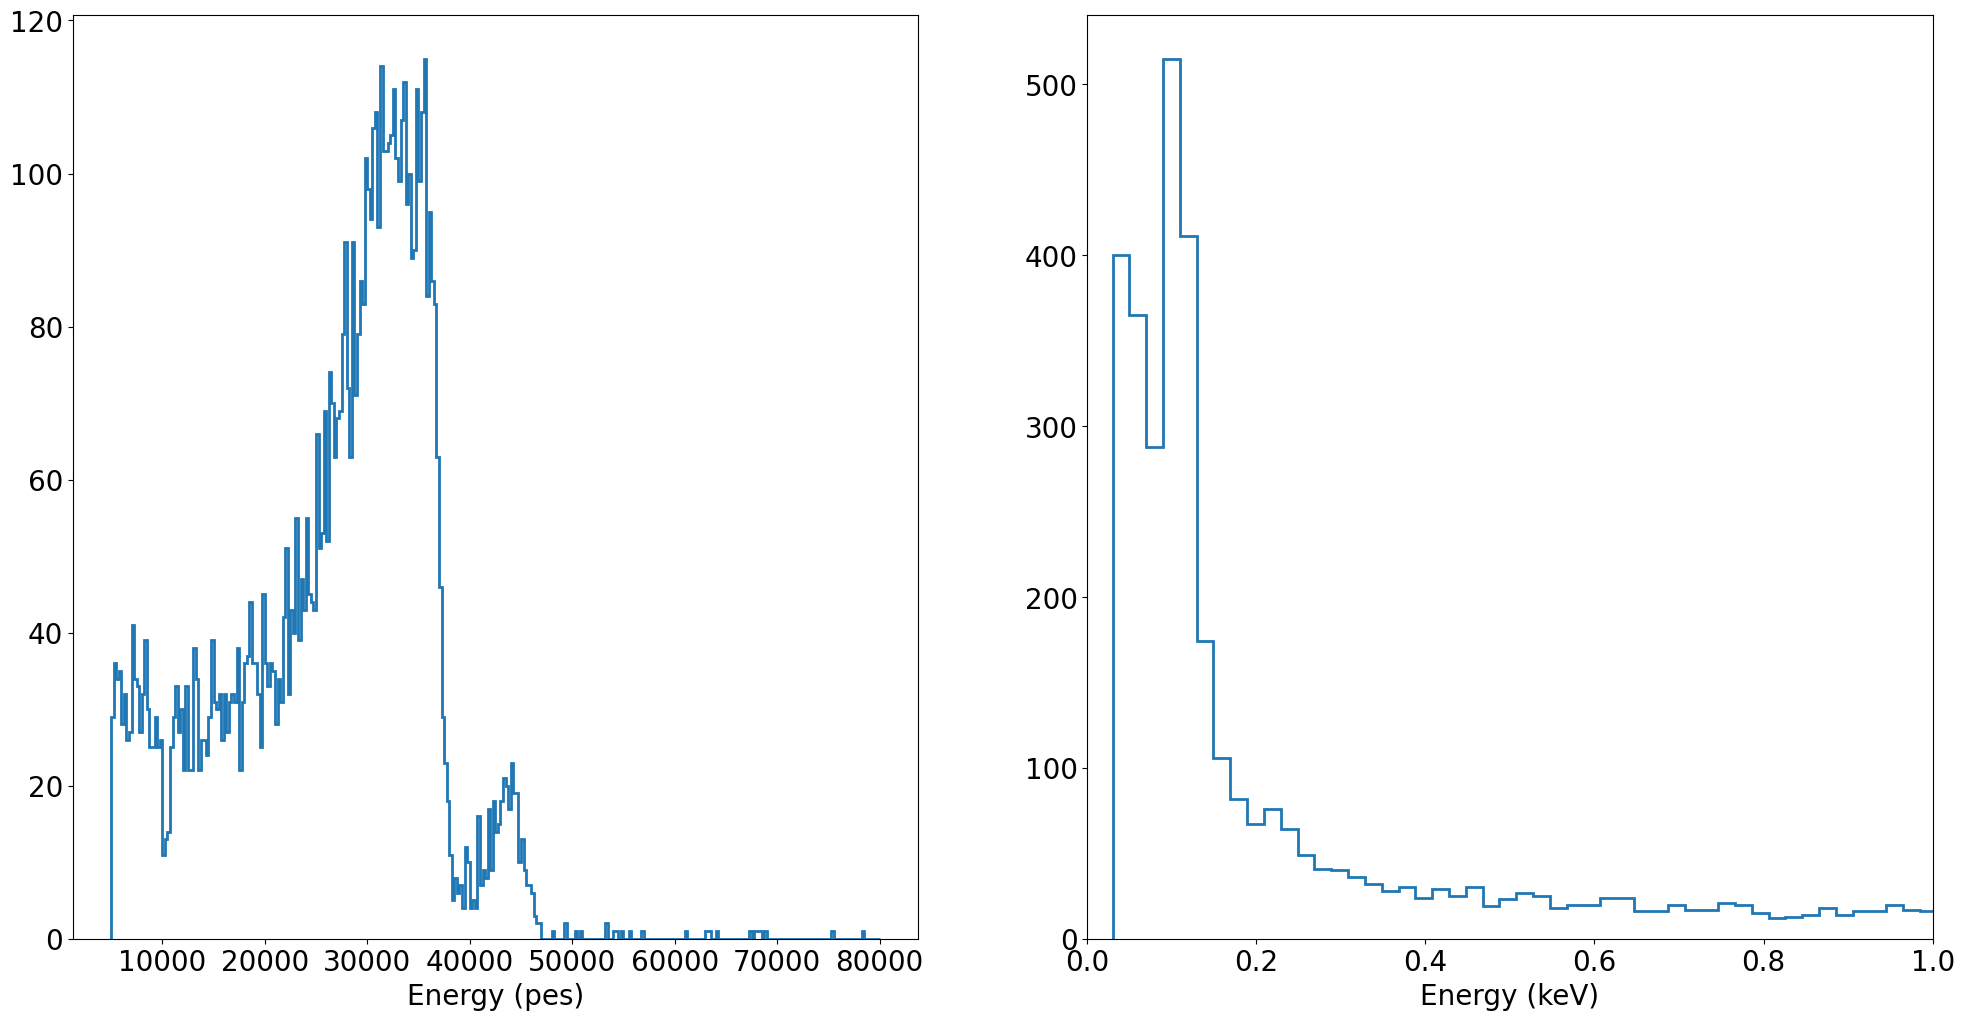

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins = np.linspace(5000, 80000, 301)
#enebins = np.linspace(00, 2000, 201)
enebins_c = np.linspace(0.03, 6, 301)
normed = False
var    = 's1_energy'
#var    = 'e_pmt0_s1'
#var    = 'ped_sum_pmt1'
#var    = 'e_pmt0'

eref = 5.9
#eref = 0.3
#eref = 5.9

y,x, *_ = axes[0].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);
x = coref.shift_to_bin_centers(x)
escale_1 = x[y.argmax()]/eref
print(x[y.argmax()])
#escale_1 = 375/eref
#enebins = np.linspace(0.01, 2, 51)
axes[1].hist(data_1_s2[var]/escale_1, enebins_c, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);

for ax in axes:
    #ax.set_yscale('log')
    pass

axes[0].set_xlabel('Energy (pes)')
axes[1].set_xlabel('Energy (keV)')

ar_xray   = [2.9, 3.2][:1]
colors    = ['b'] * len(ar_xray)
#al_xray   = [1.5]
#colors   += ['k'] * fe_lines
fe_lines  = [5.9, 6.5]
fe_lines  = [5.9]
fe_lines  = [feline*i for feline in fe_lines for i in range(1, 3)]
colors   += ['k'] * len(fe_lines)
kr_line   = [41.5]
colors   += ['g'] * len(fe_lines)
#cu_lines = [9.4]
#colors   += ['r'] * len(cu_lines)
#
#am_lines = [13.9, 17.7, 26.3, 59.6][:2] # From 2212.11515
#colors   += ['g'] * len(am_lines)
energy_lines = ar_xray  + fe_lines #+kr_line#+  am_lines

for color, line in zip(colors, energy_lines):
    axes[1].axvline(line, c=color, ls='--')
    pass
erange = [2300, 5000]
erange = [800, 1600]
erange = [400, 600]
erange = [6000, 11000]
#axes[0].axvspan(*erange, alpha=0.2)
erange = [30, 50]
#axes[1].axvspan(*erange, alpha=0.2)
sel_e_1 = coref.in_range(data_1_s2[var]/escale_1, *erange)


axes[1].set_xlim(0, 1)
#mcpath = f'/home/ander/Work/GaP/nexus_quick_sim/data/SummaryDST_55Fe_{pressure}bar.h5'
#
#mc_dst = pd.read_hdf(mcpath)

In [14]:
1.4

268.1818181818182

In [52]:
data_1_s2

,event,timestamp,x,y,r,energy,height,d_energy,d_height,ped_sum,...,ped_sum_pmt5,e0_pmt5,e_pmt6,h_pmt6,e_pmt6_s1,h_pmt6_s1,ped_sum_pmt6,e0_pmt6,file,sub_energy
0,9106224,91213935707,-0.135468,1.285262,1.292381,2084.505551,5.385563,2084.446751,3.348120,-0.618948,...,0.060306,-0.008800,240.139797,2.015772,47.150302,0.655031,1.058814,-0.039816,Run_656_file_10_raw.h5,1526.505551
1,9106282,91214098721,4.426719,0.499271,4.454786,-365143.197631,2.346656,-365141.534639,0.463862,-618.184343,...,-292.230635,-1.093258,-47012.293545,-1.175927,-18326.231836,-1.175927,-410.790802,-1.697062,Run_656_file_10_raw.h5,-365701.197631
2,9134194,91277381513,0.793671,-0.105297,0.800626,1071.122337,15.727203,1071.420998,6.679100,-0.480560,...,0.351782,-0.009589,197.934762,2.767548,88.930708,1.464711,0.347423,0.046066,Run_656_file_10_raw.h5,513.122337
3,9134438,91277698716,1.669771,-1.110418,2.005284,30280.186925,35.071241,30279.625870,32.358495,-0.691545,...,0.073707,-0.033027,2129.739157,3.983548,101.027105,2.072720,0.670031,-0.011820,Run_656_file_10_raw.h5,29722.186925
4,9134575,91277972486,1.353902,-0.996516,1.681099,18013.072218,21.446553,18013.334851,19.521489,-0.431788,...,-0.154114,-0.056136,1344.650784,2.681133,92.185734,1.349344,0.852014,-0.011397,Run_656_file_10_raw.h5,17455.072218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15414,9105866,91212703277,10.304900,-4.097463,11.089642,-469.915762,1.064183,-470.280136,0.503561,-0.498770,...,-0.110560,0.010766,2.829018,0.187002,3.945736,0.187002,-0.194392,-0.015662,Run_656_file_9_raw.h5,-1027.915762
15415,9105905,91212860299,1.741783,-0.805930,1.919201,30562.268386,40.935962,30562.901273,38.318611,-0.428269,...,-0.137363,-0.009783,2120.030606,3.983291,96.790471,2.188270,1.133262,0.045827,Run_656_file_9_raw.h5,30004.268386
15416,9105991,91213157778,-35.275357,1.777337,35.320104,85.582142,1.050656,85.339468,0.425486,-0.773408,...,0.070356,-0.009172,66.077977,0.249244,27.050762,0.249244,0.955414,0.017629,Run_656_file_9_raw.h5,-472.417858
15417,9106039,91213343522,1.647042,-1.053717,1.955266,32184.741868,44.441687,32184.711556,41.437515,-0.510127,...,0.060306,-0.008800,2296.509223,4.100312,93.212838,1.118262,1.087766,0.075992,Run_656_file_9_raw.h5,31626.741868


188500.0


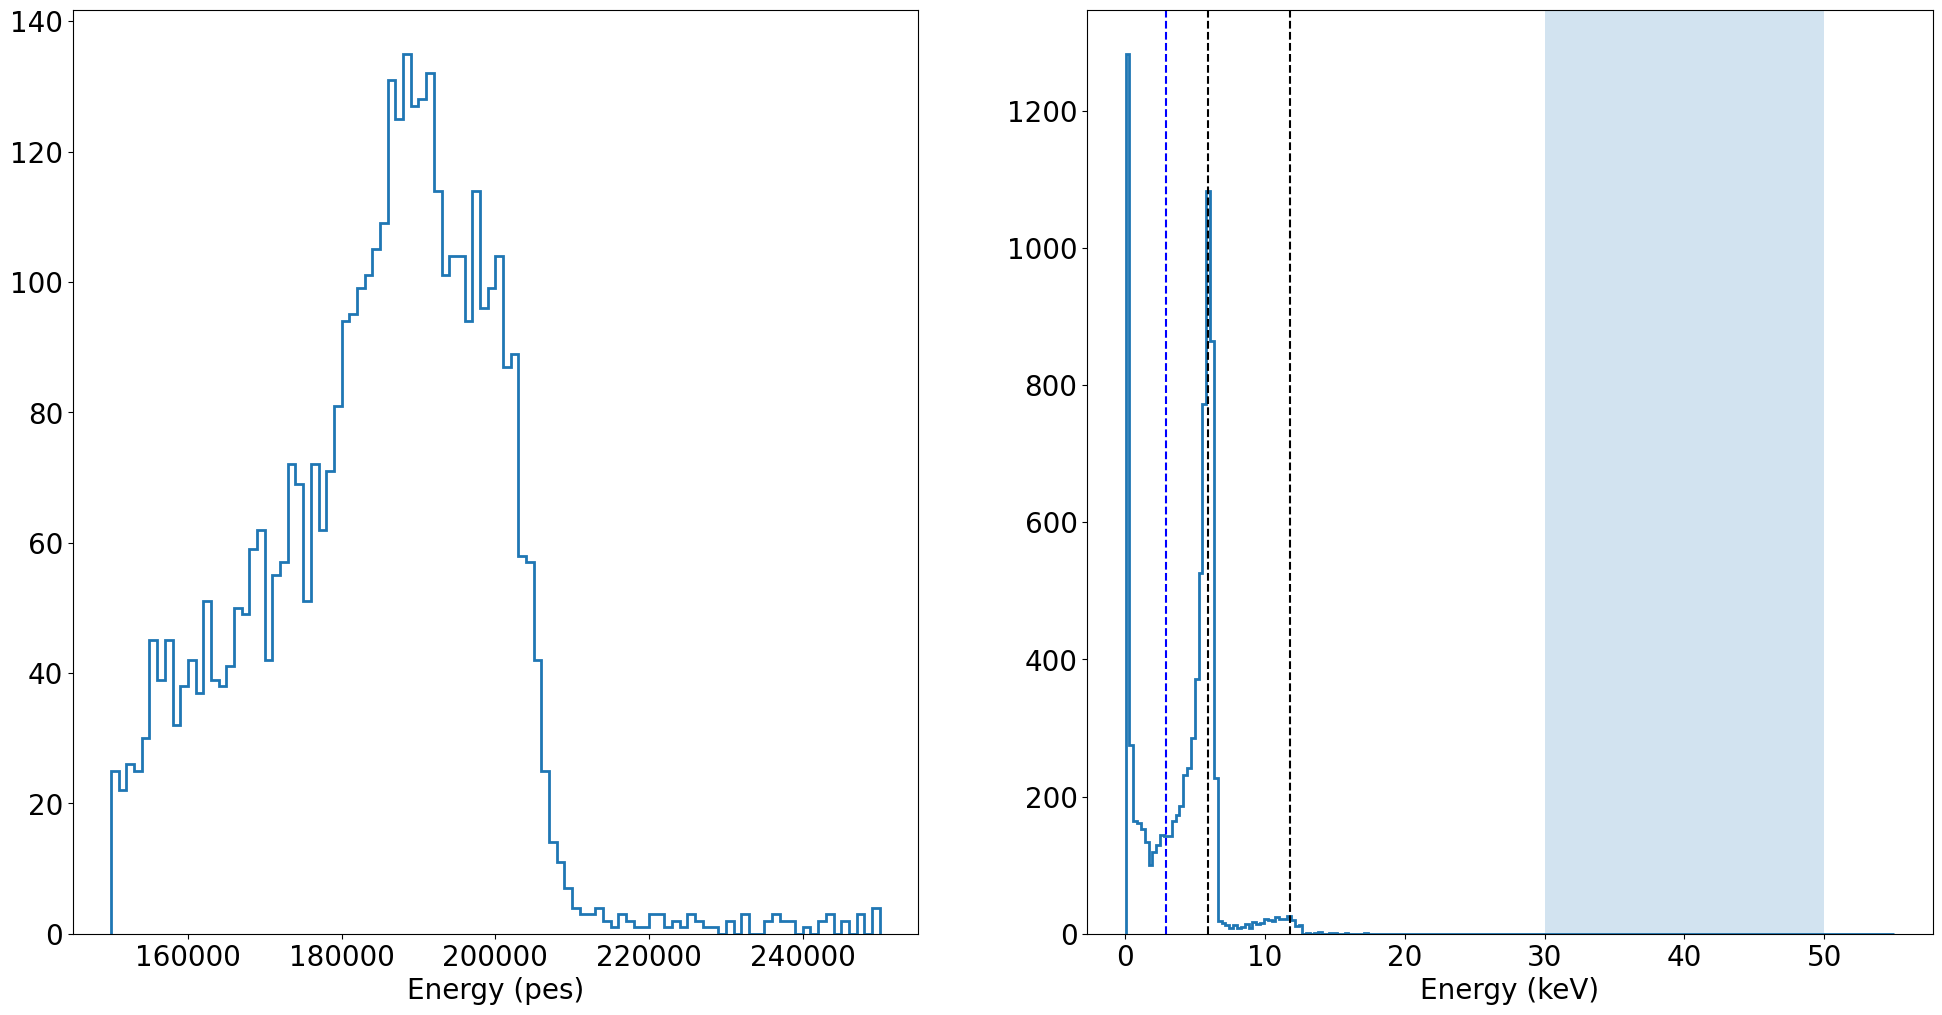

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins = np.linspace(150e3, 250000, 101)
#enebins = np.linspace(00, 2000, 201)
enebins_c = np.linspace(0.03, 55, 201)
normed = False
var    = 'sub_energy'
#var    = 'e_pmt0'

eref = 5.9
#eref = 0.3
#eref = 5.9

y,x, *_ = axes[0].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);
x = coref.shift_to_bin_centers(x)
escale_1 = x[y.argmax()]/eref
print(x[y.argmax()])
#escale_1 = 375/eref
#enebins = np.linspace(0.01, 2, 51)
axes[1].hist(data_1_s2[var]/escale_1, enebins_c, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);

for ax in axes:
    #ax.set_yscale('log')
    pass

axes[0].set_xlabel('Energy (pes)')
axes[1].set_xlabel('Energy (keV)')

ar_xray   = [2.9, 3.2][:1]
colors    = ['b'] * len(ar_xray)
#al_xray   = [1.5]
#colors   += ['k'] * fe_lines
fe_lines  = [5.9, 6.5]
fe_lines  = [5.9]
fe_lines  = [feline*i for feline in fe_lines for i in range(1, 3)]
colors   += ['k'] * len(fe_lines)
kr_line   = [41.5]
colors   += ['g'] * len(fe_lines)
#cu_lines = [9.4]
#colors   += ['r'] * len(cu_lines)
#
#am_lines = [13.9, 17.7, 26.3, 59.6][:2] # From 2212.11515
#colors   += ['g'] * len(am_lines)
energy_lines = ar_xray  + fe_lines #+kr_line#+  am_lines

for color, line in zip(colors, energy_lines):
    axes[1].axvline(line, c=color, ls='--')
    pass
erange = [2300, 5000]
erange = [800, 1600]
erange = [400, 600]
erange = [6000, 11000]
#axes[0].axvspan(*erange, alpha=0.2)
erange = [30, 50]
axes[1].axvspan(*erange, alpha=0.2)
sel_e_1 = coref.in_range(data_1_s2[var]/escale_1, *erange)



#mcpath = f'/home/ander/Work/GaP/nexus_quick_sim/data/SummaryDST_55Fe_{pressure}bar.h5'
#
#mc_dst = pd.read_hdf(mcpath)

In [43]:
575 / (5495000/40)*100

0.41856232939035487

In [30]:
556 * 5495 / 59.5

51348.23529411765

In [24]:
131000 * 59.5/5495

1418.4713375796177

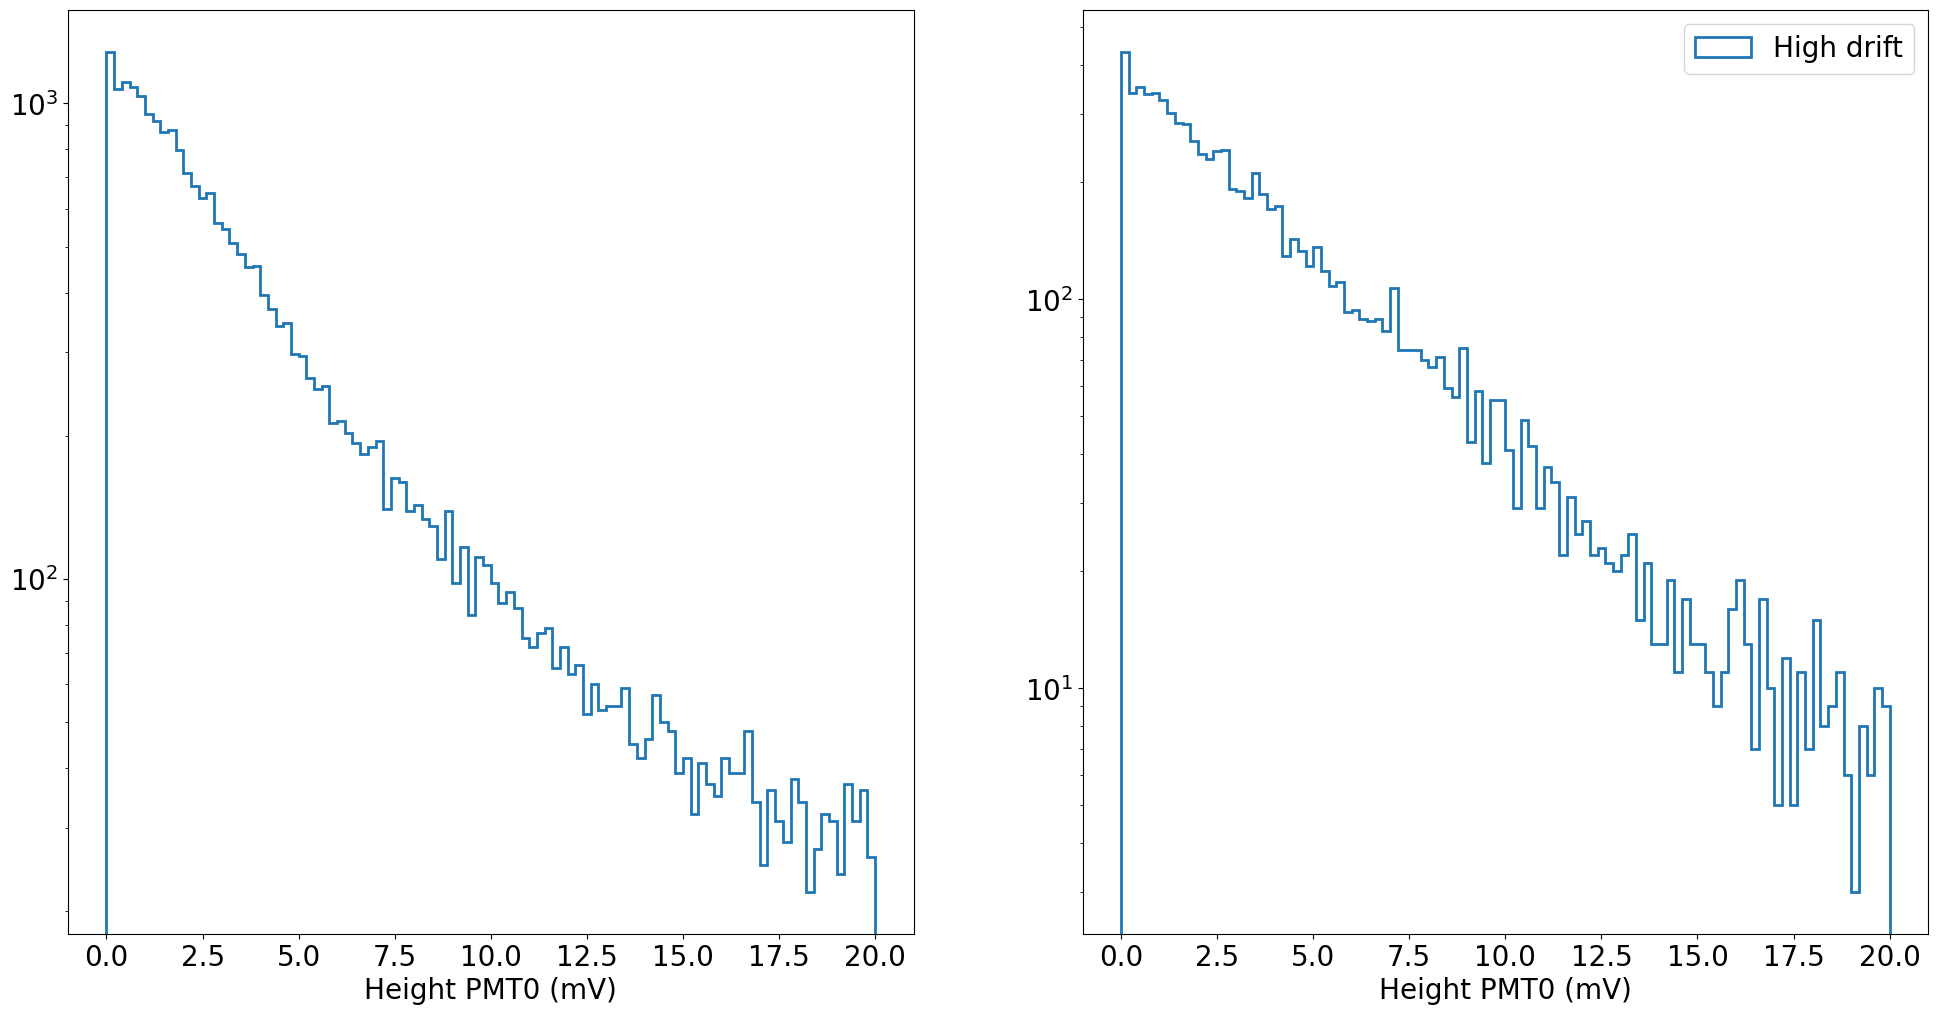

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins = np.linspace(0000, 20, 101)
normed = False
var    = 's1_energy'
sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 & sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
#sel1 = sel1 & sel_r_1

axes[0].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);

axes[1].hist(data_1_s2[var][sel1], enebins, histtype='step', 
         lw=2, weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], label=label_1);

for ax in axes:
    ax.set_xlabel('Height PMT0 (mV)')
    ax.set_yscale('log')
trange = [15500, 18000]
trange = [10000, 18000]
sel_t_1 = coref.in_range(data_1_s2[var], *trange)
plt.legend()

#### XY pos

In [28]:
data_pmt = db.DataPMT('gap', 1)
xpmt = data_pmt.X.values
ypmt = data_pmt.Y.values

In [29]:
sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 & sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
###sel1 = sel1 & sel_r_1

In [30]:
len(data_1_s2[sel1])/3600

9.805555555555555

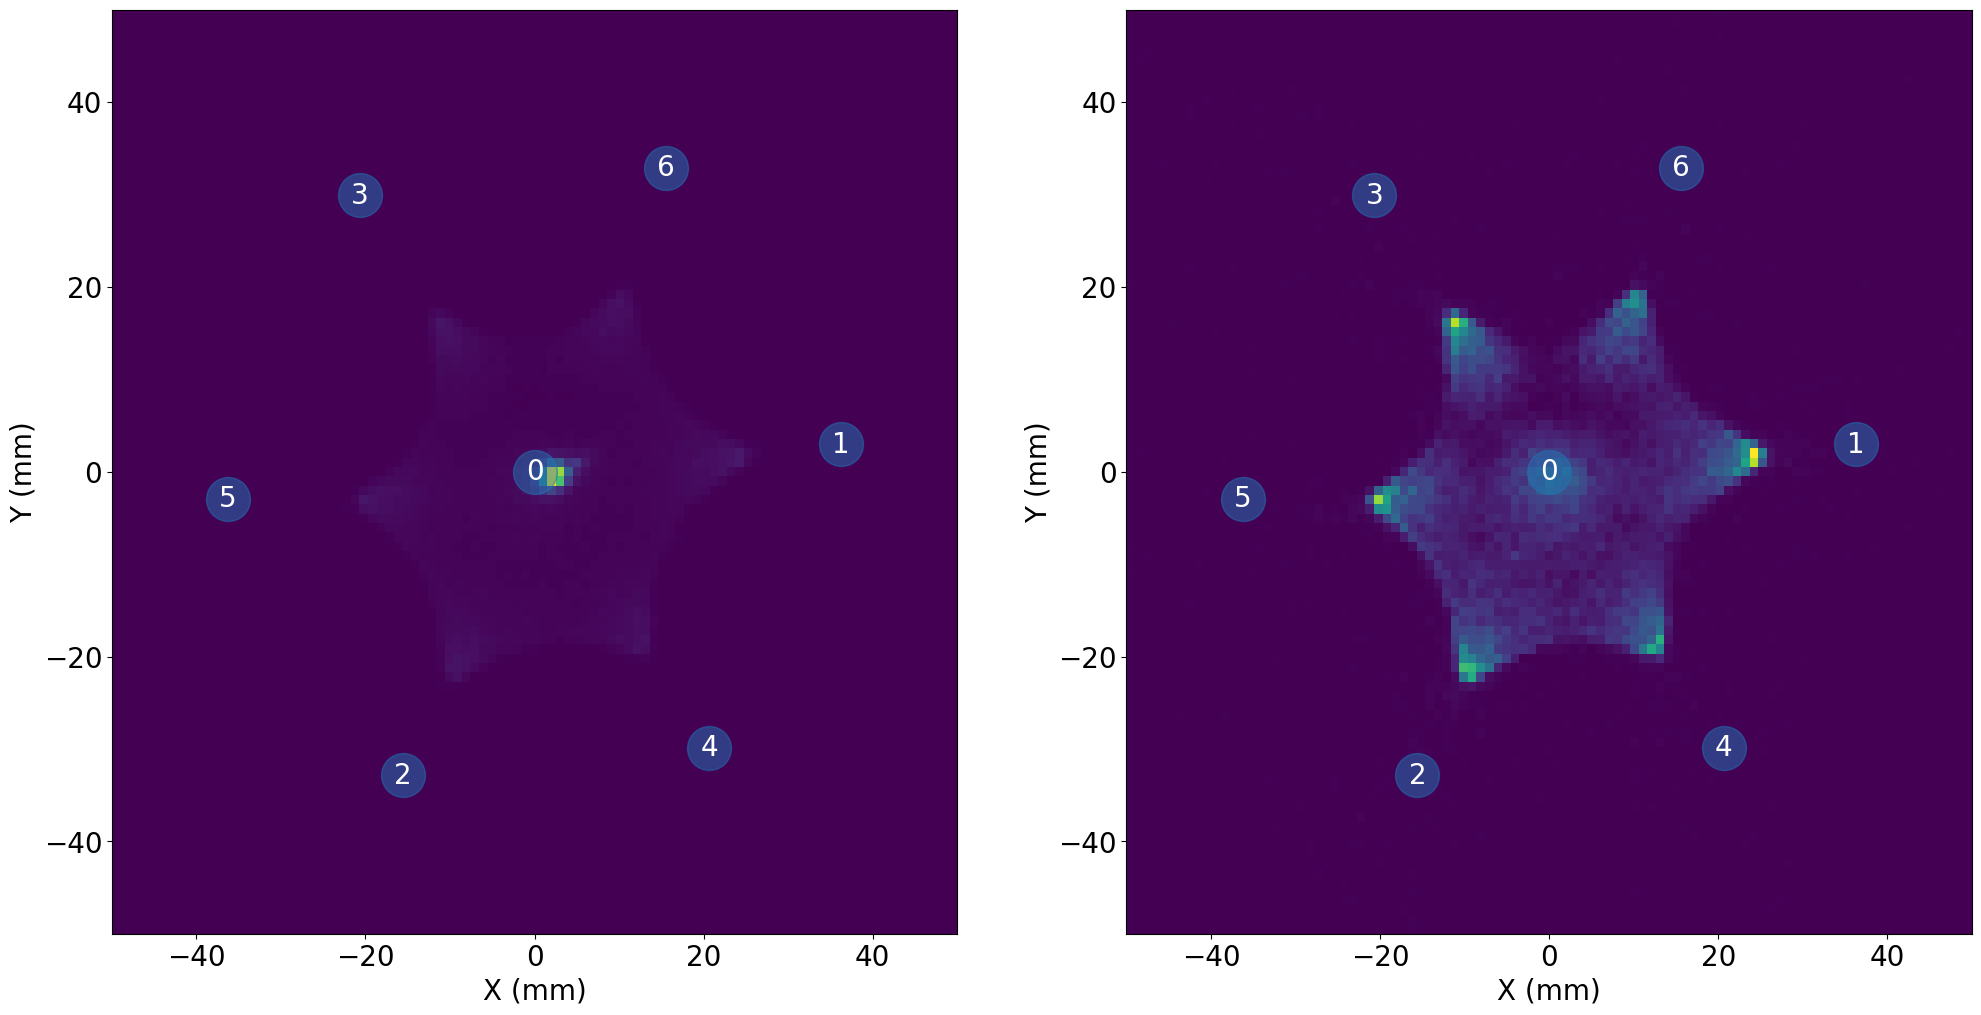

In [38]:
xybins = np.linspace(-50, 50, 100)

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].hist2d(data_1_s2.x, data_1_s2.y, xybins)#, norm = colors.LogNorm());
axes[1].hist2d(data_1_s2[sel1].x, data_1_s2[sel1].y, xybins);

for ax in axes:
    ax.scatter(xpmt, ypmt, s=1000, alpha=0.5)
    for i in range(7):
        ax.text(xpmt[i], ypmt[i], f'{i}', c='w', horizontalalignment='center', verticalalignment='center')
        
for ax in axes:
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')

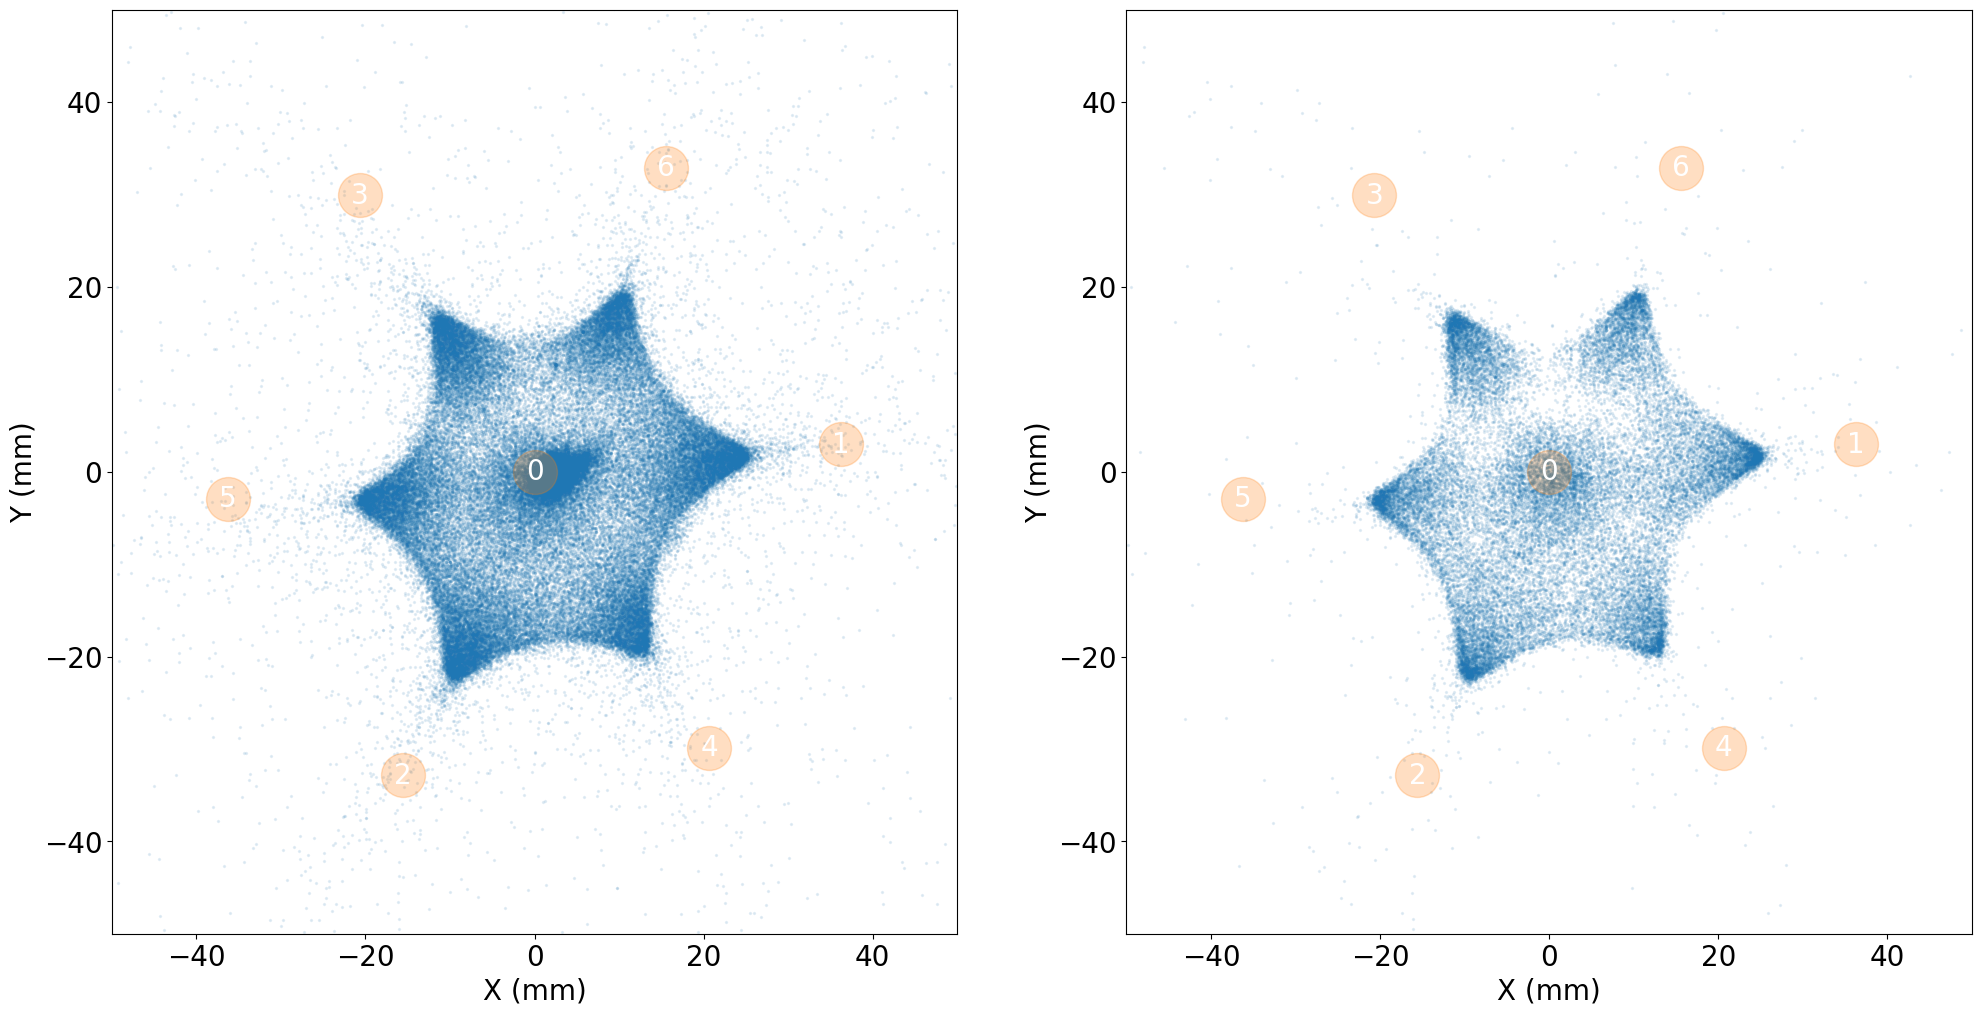

In [37]:
xybins = np.linspace(-50, 50, 100)

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].scatter(data_1_s2.x, data_1_s2.y, s=2, alpha=0.1);
axes[1].scatter(data_1_s2[sel1].x, data_1_s2[sel1].y, s=2, alpha=0.1);

for ax in axes:
    ax.scatter(xpmt, ypmt, s=1000, alpha=0.25)
    ax.set_xlim(xybins[0], xybins[-1])
    ax.set_ylim(xybins[0], xybins[-1])
    #ax.legend()
    for i in range(7):
        ax.text(xpmt[i], ypmt[i], f'{i}', c='w', horizontalalignment='center', verticalalignment='center')
      
xrange = [9, 14]
yrange = [-8.5, -13.5]

for ax in axes:
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
#axes[1].axvspan(*xrange, alpha=0.2)
#axes[1].axhspan(*yrange, alpha=0.2)

In [43]:
rmax = 2
sel_r_1 = np.sqrt(data_1_s2.x**2 + data_1_s2.y**2) < rmax
sel_xy_1 = coref.in_range(data_1_s2.x, *xrange) & coref.in_range(data_1_s2.y, *yrange[::-1])

2.6638888888888888


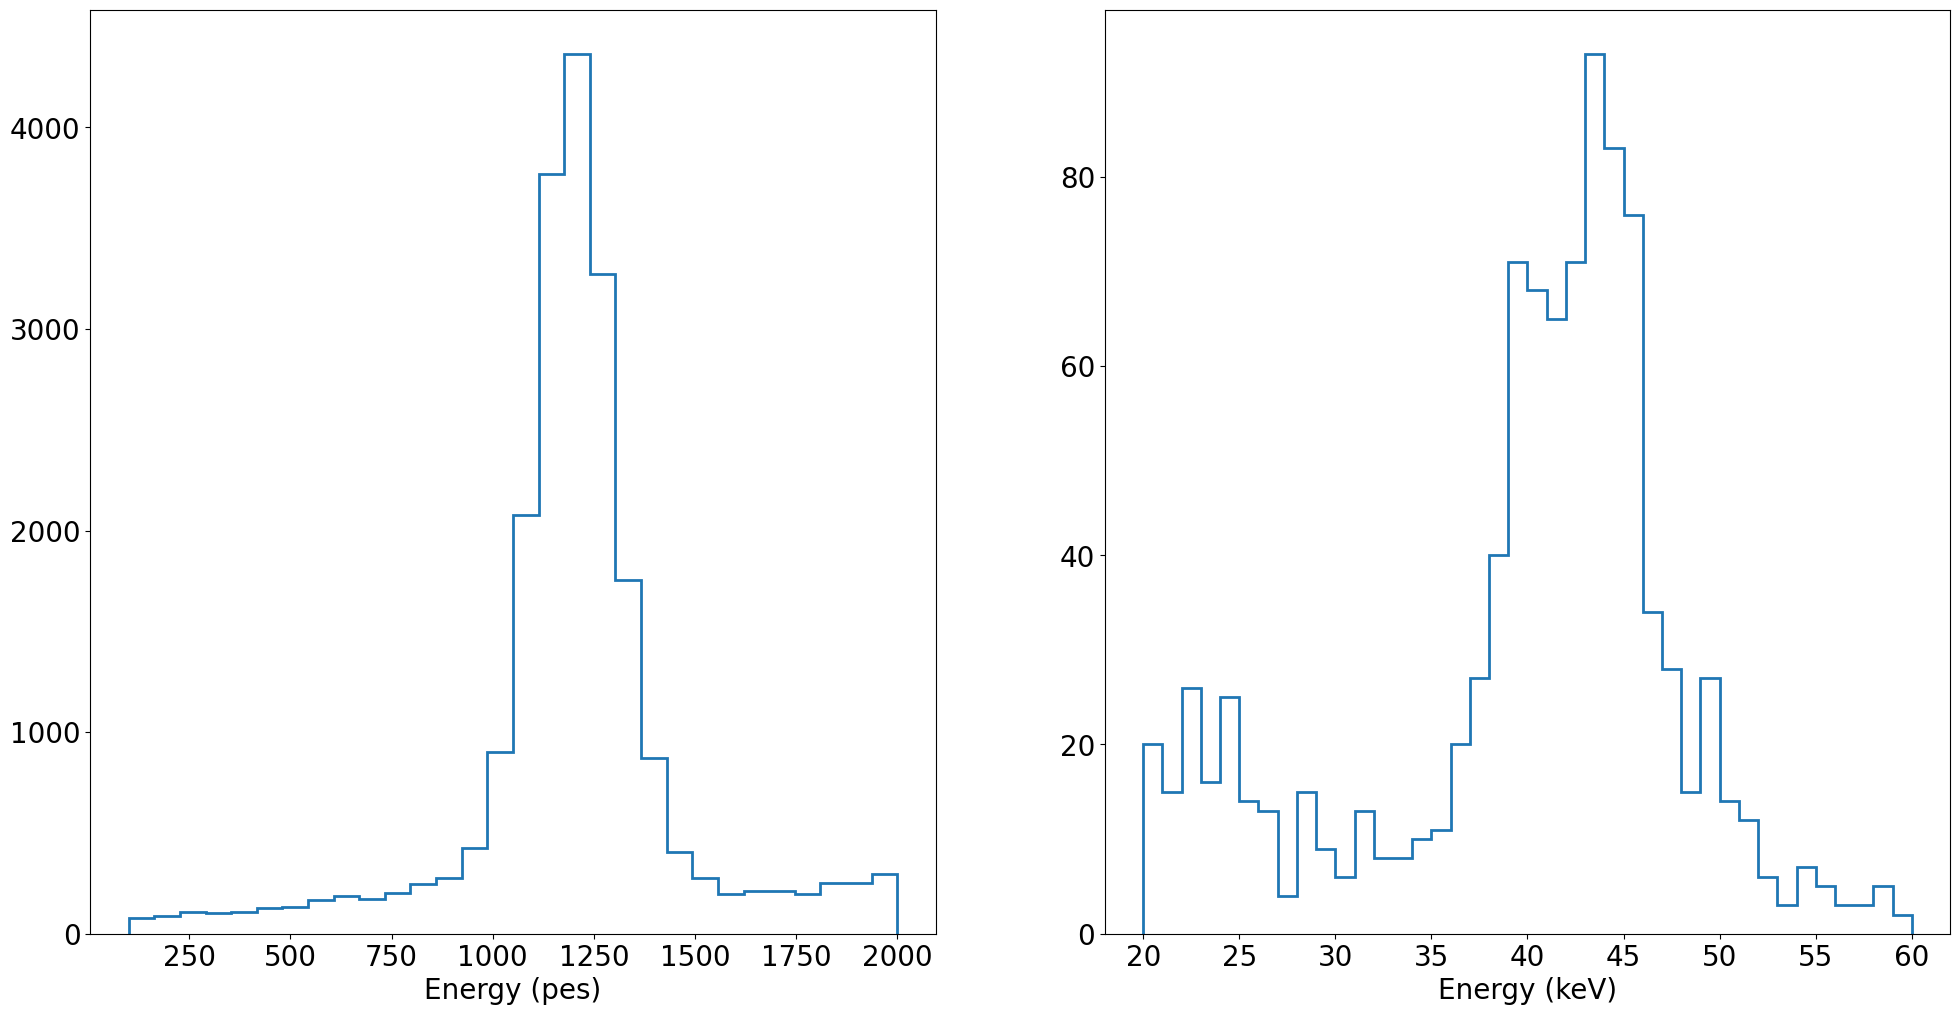

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins = np.linspace(100, 2000, 31)
#enebins = np.linspace(0000, 400, 251)
normed = False
var    = 'energy'


sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 #& sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
sel1 = sel1 & sel_r_1
print(len(data_1_s2[sel1])/3600)
eref = 5.9
#eref = 41.5

y,x, *_ = axes[0].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);
x = coref.shift_to_bin_centers(x)
escale_1 = x[y.argmax()]/eref
#escale_1 = 525/eref
#escale_1 = 1
#print(x[y.argmax()])
enebins = np.linspace(20, 60, 41)
#enebins = np.linspace(0, 60, 101)
axes[1].hist(data_1_s2[var][sel1]/escale_1, enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2)[sel1] if normed else weights_1_s2[sel1], label=label_1);
#axes[1].hist(data_1_s2[var][sel1], enebins, histtype='step', 
#         lw=2, weights=weights_1_s2/len(data_1_s2)[sel1] if normed else weights_1_s2[sel1], label=label_1);

for ax in axes:
    #ax.set_yscale('log')
    pass
axes[0].set_xlabel('Energy (pes)')
axes[1].set_xlabel('Energy (keV)')

ar_xray   = [2.9, 3.2]
colors    = ['b'] * len(ar_xray)
#al_xray   = [1.5]
#colors   += ['k'] * fe_lines
fe_lines  = [5.9, 6.5]
colors   += ['k'] * len(fe_lines)
cu_lines = [9.4]
colors   += ['r'] * len(cu_lines)

am_lines = [13.9, 17.7, 26.3, 59.6][:3] # From 2212.11515
colors   += ['g'] * len(am_lines)
am_lines2 = [am - 3 for am in am_lines]
colors   += ['olive'] * len(am_lines)
energy_lines = ar_xray  + fe_lines + cu_lines +  am_lines + am_lines2

for color, line in zip(colors, energy_lines):
    #axes[1].axvline(line, c=color, ls='--')
    pass
#erange = [2500, 4500]
#axes[0].axvspan(*erange, alpha=0.2)
#axes[1].axvspan(*erange, alpha=0.2)
sel_e_1 = coref.in_range(data_1_s2[var], *erange)
#len()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


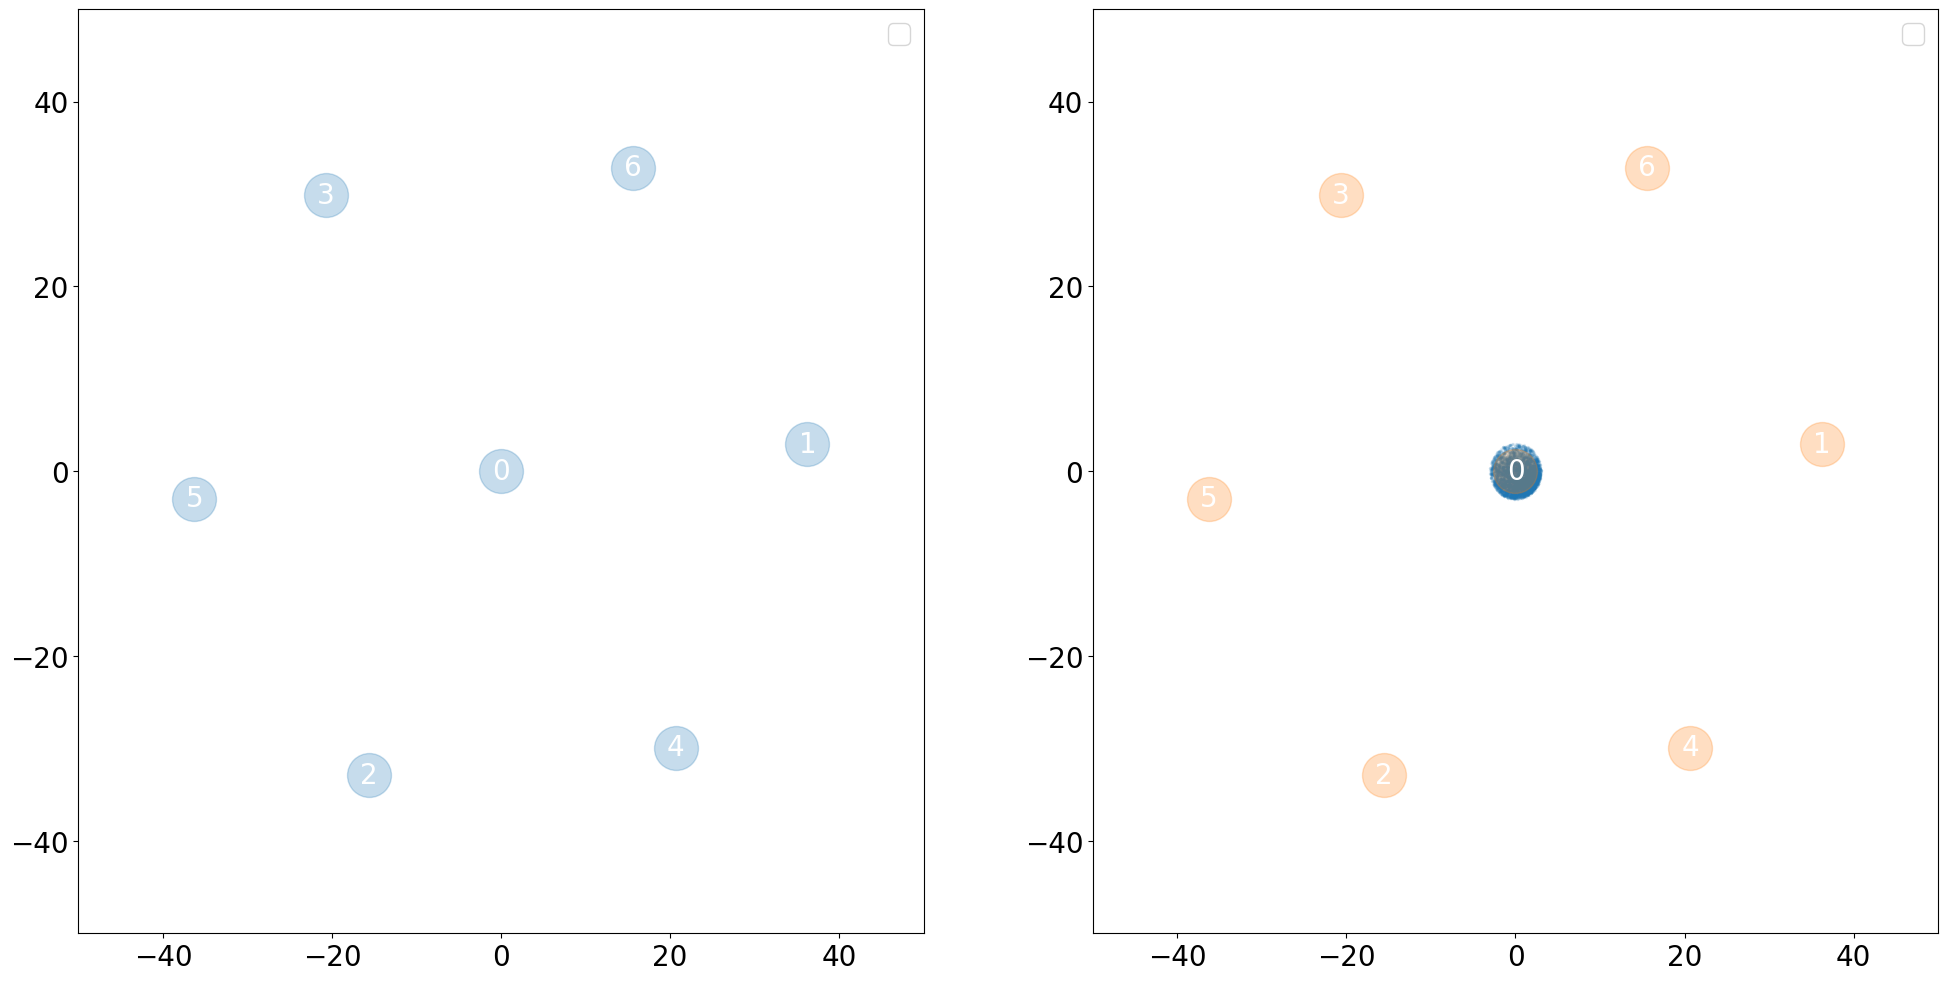

In [30]:
xybins = np.linspace(-50, 50, 100)

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

#axes[0].scatter(data_1_s2.x, data_1_s2.y, s=2, alpha=0.1);
axes[1].scatter(data_1_s2[sel1].x, data_1_s2[sel1].y, s=2, alpha=0.1);

for ax in axes:
    ax.scatter(xpmt, ypmt, s=1000, alpha=0.25)
    ax.set_xlim(xybins[0], xybins[-1])
    ax.set_ylim(xybins[0], xybins[-1])
    ax.legend()
    for i in range(7):
        ax.text(xpmt[i], ypmt[i], f'{i}', c='w', horizontalalignment='center', verticalalignment='center')
      
xrange = [9, 14]
yrange = [-8.5, -13.5]
#axes[1].axvspan(*xrange, alpha=0.2)
#axes[1].axhspan(*yrange, alpha=0.2)

### Energy resolution

In [17]:
fano = 0.15
wi   = 22
data_pmt = db.DataPMT('gap', 1)
pmt_sigma = (data_pmt.Sigma/data_pmt.adc_to_pes).mean()

def get_intrinsic_resolution(energy, fano, wi, det_phot, pmt_sigma):
    fano_term =  fano / (energy/wi)
    det_term  = (1+pmt_sigma**2)/det_phot
    return 235 * np.sqrt(fano_term + det_term)

def el_yield(p, kv):
    return (81*kv/p - 47)*p

E resolution =  46.58%
Intrinsic resolution = 10.706143206267903%
Light collection eff = 0.657%
808.9560817711242


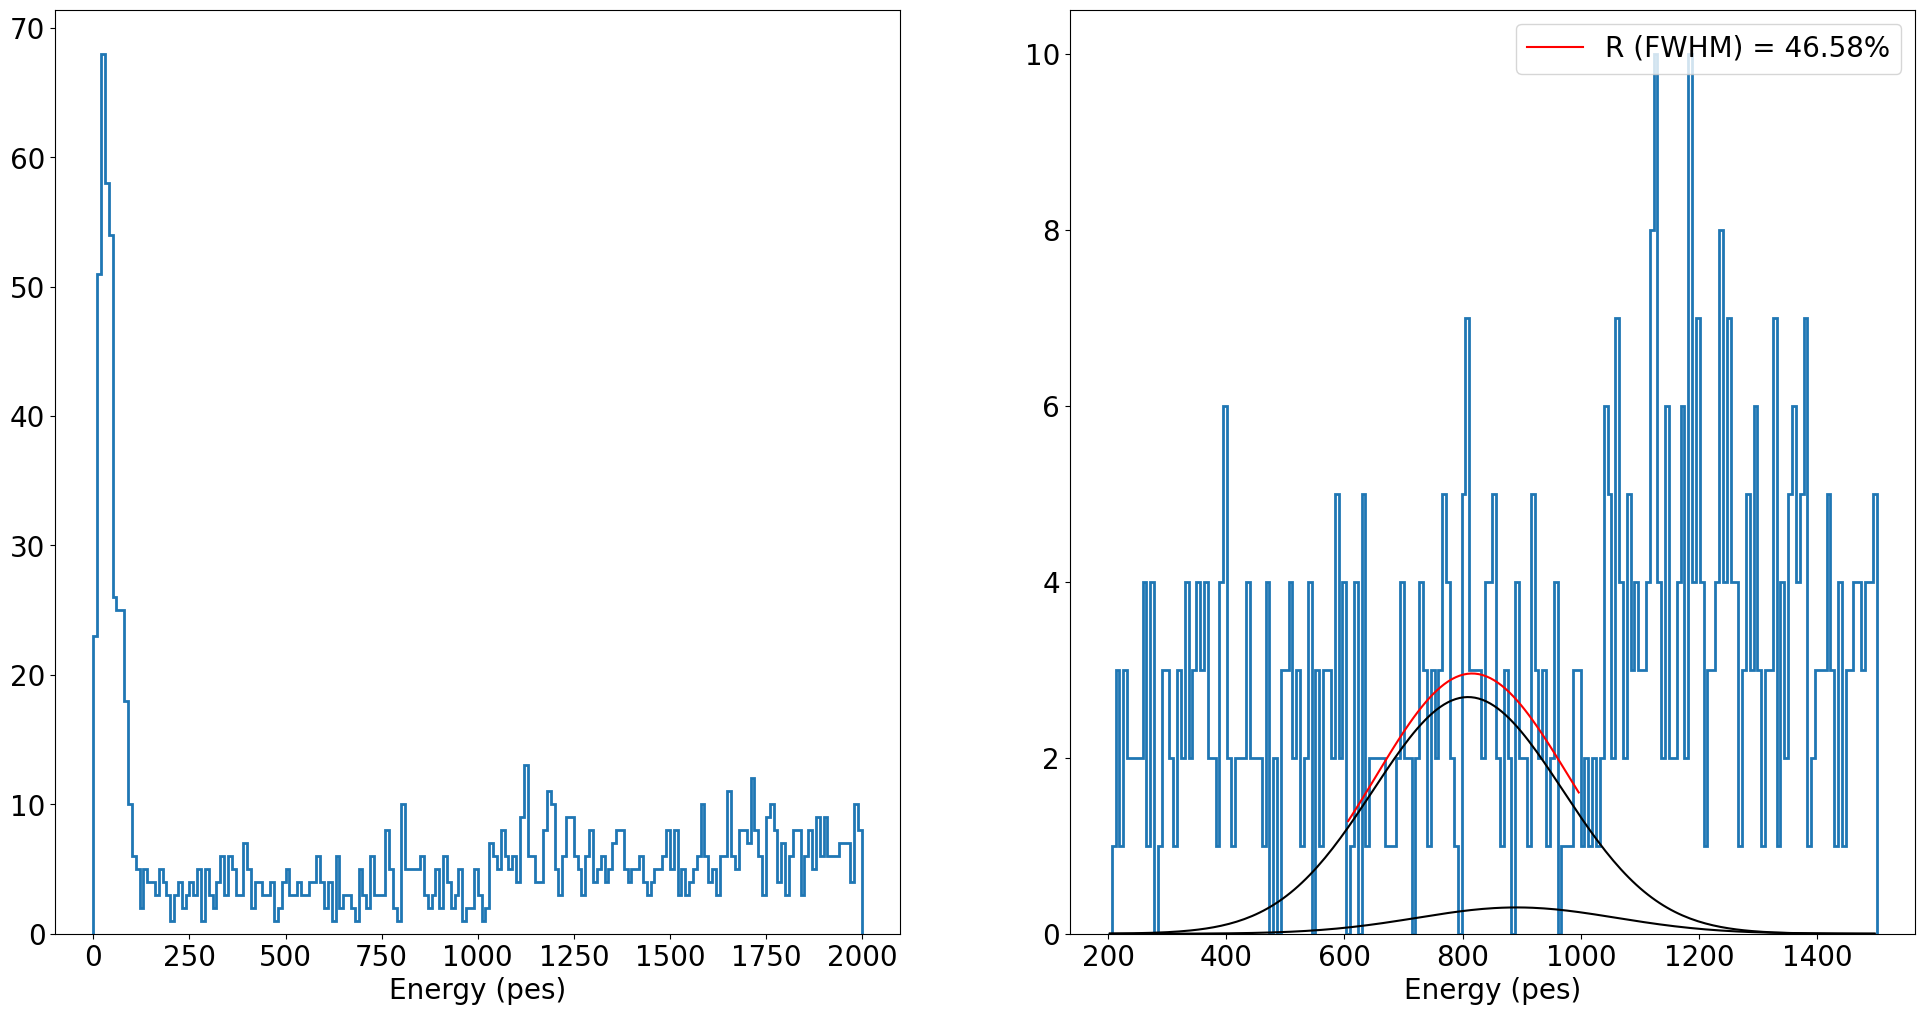

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins = np.linspace(0, 2000, 201)
#enebins = np.linspace(0000, 400, 251)
normed = False
var    = 'energy'

eref = 2.9
eref = 5.9

y,x, *_ = axes[0].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2);
x = coref.shift_to_bin_centers(x)
escale_1 = x[y.argmax()]/eref

enebins = np.linspace(200, 1500, 201)
yd, xd, *_ = axes[1].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2);
xd = coref.shift_to_bin_centers(xd)

for ax in axes:
    #ax.set_yscale('log')
    pass

axes[0].set_xlabel('Energy (pes)')
axes[1].set_xlabel('Energy (pes)')


erange = [600, 1000]
#axes[1].axvspan(*erange, alpha=0.2)
sel_e_1 = coref.in_range(data_1_s2[var], *erange)

efit = [600, 1000]
sel_f = coref.in_range(xd, *efit)

centers   = np.array([5.9, 6.5])
int_ratio = np.array([11142, 1299])

mod  = GaussianModel(prefix='g1_')
pars = mod.guess(yd[sel_f], x=xd[sel_f])

for i in range(1, len(centers)):
    g = GaussianModel(prefix=f'g{i+1}_')
    mod += g
    params = g.make_params(center=pars['g1_center'],
                            sigma=pars['g1_sigma'],
                            amplitude=pars['g1_amplitude'])
    params[f'g{i+1}_center'].set(value=pars['g1_center'], vary=True, expr=f'g1_center*{centers[i]/centers[0]}')
    params[f'g{i+1}_sigma'].set(value=pars['g1_center'], vary=True, expr=f'g1_sigma*{np.sqrt(centers[i]/centers[0])}')
    params[f'g{i+1}_amplitude'].set(value=pars['g1_center'], vary=True, expr=f'g1_amplitude*{int_ratio[i]/int_ratio[0]}')
    pars.update(params)

out  = mod.fit(yd[sel_f], pars, x=xd[sel_f])

result =  out.result.params
mu     = [result['g1_center'].value, result['g1_center'].stderr]
sigma  = [result['g1_sigma' ].value, result['g1_sigma' ].stderr]
reso   = sigma[0]/mu[0] * 235
print(f'E resolution =  {reso:.2f}%')
print(f'Intrinsic resolution = {get_intrinsic_resolution(eref*1000, fano, wi, mu[0], pmt_sigma)}%')
#fitf.gauss()
axes[1].plot(xd[sel_f], out.best_fit, '-', c='r', label=f'R (FWHM) = {reso:.2f}%')
axes[1].legend()
for i in range(1, len(centers)+1):
    plt.plot(xd, fitf.gauss(xd, 
                            result[f'g{i}_amplitude'].value, result[f'g{i}_center'].value, result[f'g{i}_sigma'].value),
                            c='k')
    
    
pressure  = 6.6
el_volt   = 9.5
wi        = 22 / 1000 #divide to pass to keV
lyield    = el_yield(pressure, el_volt)
#light_col = 0.0045
light_col = mu[0]/(lyield * eref/wi) * 100
#= lyield * smeared_energy_2/wi * light_col


print(f'Light collection eff = {light_col:.3f}%')
print(mu[0])

In [26]:
300/22*lyield*0.00638

39.95910000000001

In [27]:
get_intrinsic_resolution(eref*1000, fano, wi, mu[0], pmt_sigma)

9.250444320717362

#### Radial dependance

Text(0, 0.5, 'Energy (pes)')

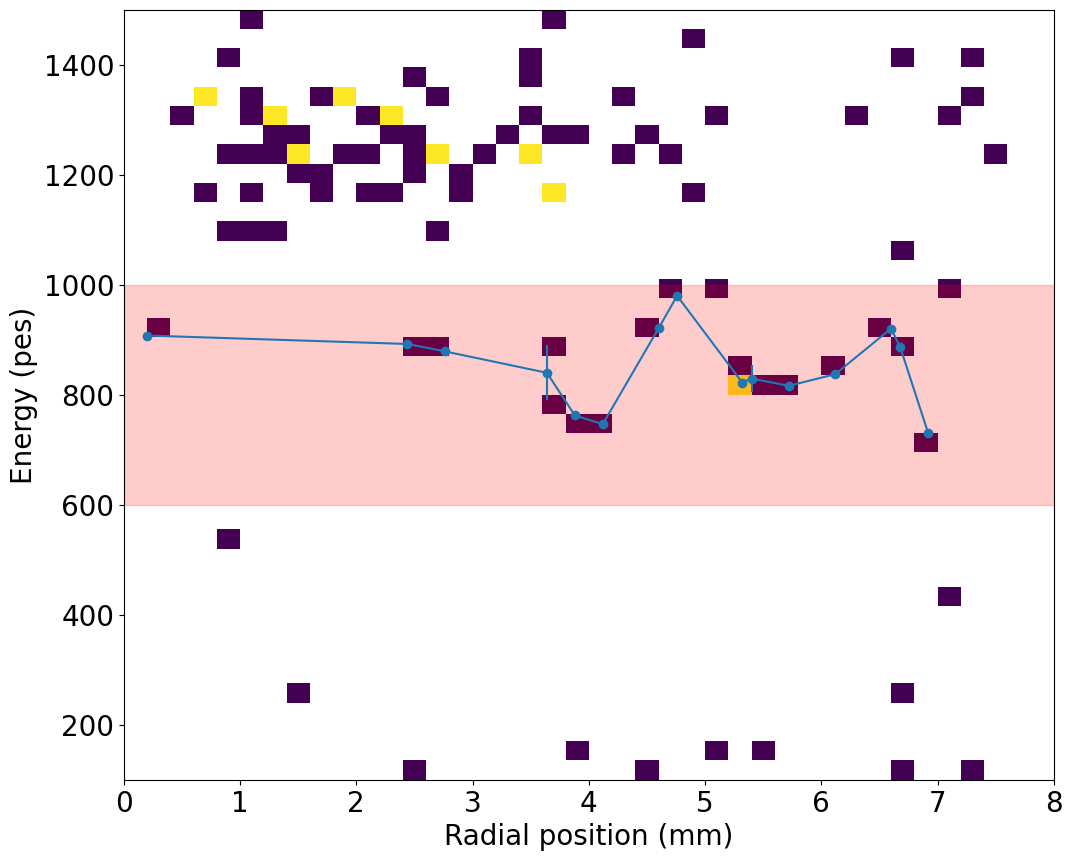

In [29]:
enebins   = np.linspace(100, 1500, 41)
rbins     = np.sqrt(np.linspace(0, 8**2, 41))
rbins     = np.linspace(0, 8, 41)

normed = False
var1   = 'r'
var2   = 'energy'

sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 #& sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
#sel1 = sel1 & sel_r_1

h, x, y, *_ = plt.hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1], [rbins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());
rprof = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1], xrange=[rbins[0], rbins[-1]], yrange=erange, nbins=100)
plt.errorbar(rprof[0], rprof[1], yerr=rprof[2], marker='o')

rrange = [0, 3]
sel_r_1 = coref.in_range(data_1_s2[var1], *rrange)

plt.axhspan(*erange, alpha=0.2, color='r')
plt.xlabel('Radial position (mm)')
plt.ylabel('Energy (pes)')

Text(0, 0.5, 'Energy (pes)')

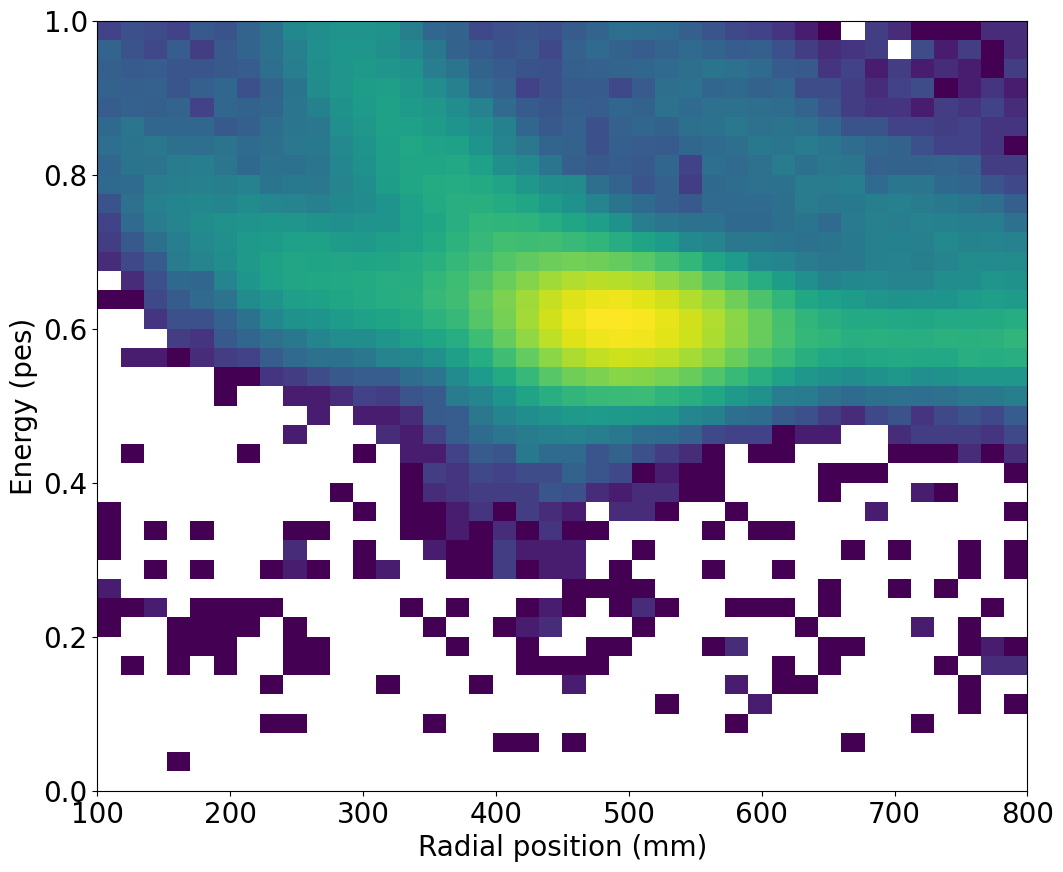

In [51]:
enebins   = np.linspace(0, 1, 41)
rbins     = np.sqrt(np.linspace(0, 8**2, 41))
rbins     = np.linspace(100, 800, 41)

normed = False
var1   = 'energy'
var2   = 'e_pmt0'
var3   = 'energy'

sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 #& sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
#sel1 = sel1 & sel_r_1

h, x, y, *_ = plt.hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1]/data_1_s2[var3][sel1], [rbins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());
rprof = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1], xrange=[rbins[0], rbins[-1]], yrange=erange, nbins=100)
plt.errorbar(rprof[0], rprof[1], yerr=rprof[2], marker='o')

rrange = [0, 3]
sel_r_1 = coref.in_range(data_1_s2[var1], *rrange)

plt.axhspan(*erange, alpha=0.2, color='r')
plt.xlabel('Radial position (mm)')
plt.ylabel('Energy (pes)')

#### Width dependance

In [30]:
import scipy.interpolate as interpolate

def find_nearest_id(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

KeyError: 'width'

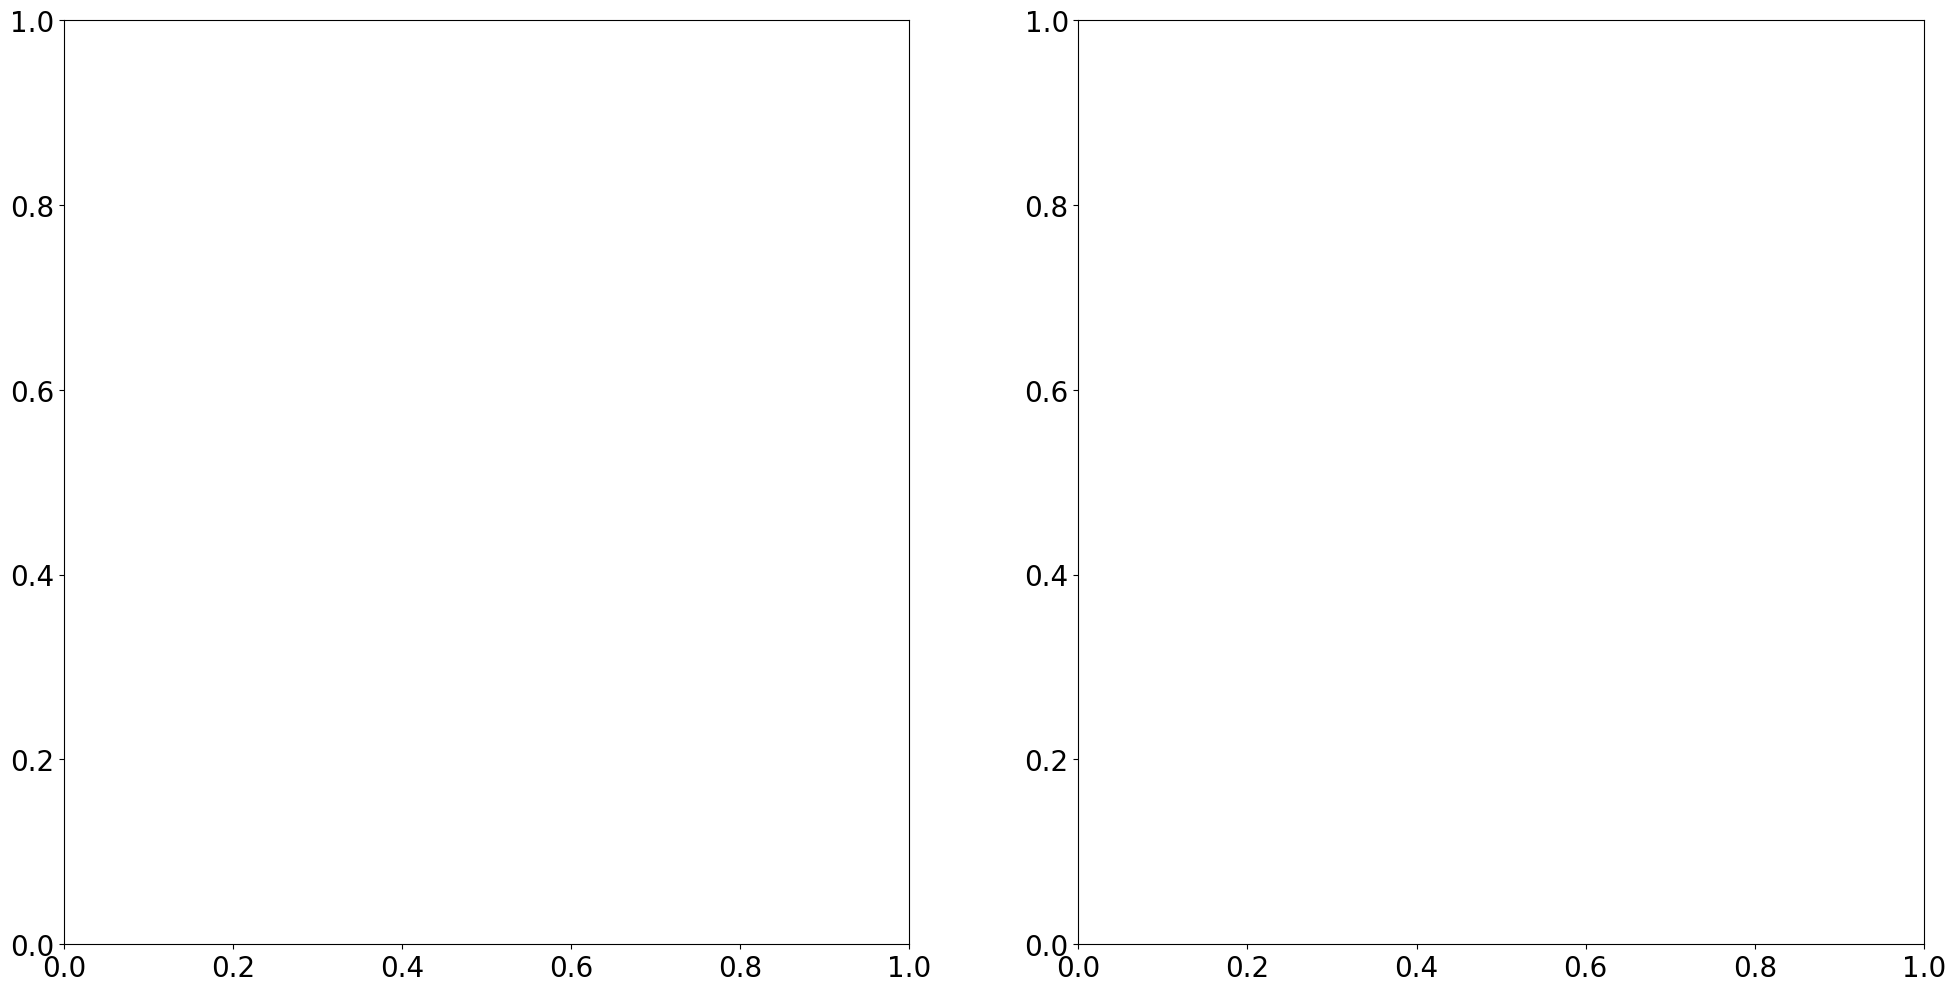

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins   = np.linspace(200, 1000, 41)
wbins     = np.linspace(0, 30000, 101)

normed = False
var1   = 'width'
var2   = 'energy'

sel1 = np.full(len(data_1_s2), True)

#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
#sel1 = sel1 & sel_r_1

h, x, y, *_ = axes[0].hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1], [wbins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());

#sel1 = sel1 & sel_e_1 
wprof = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1], xrange=[wbins[0], wbins[-1]], yrange=erange, nbins=100)
axes[0].errorbar(wprof[0], wprof[1], yerr=wprof[2], marker='o')

wrange = [15e3, 17e3]
sel_w_1 = coref.in_range(data_1_s2[var1], *wrange)

xref  = 15e3
yref  = wprof[1][find_nearest_id(wprof[0], xref)]
wcorr = interpolate.interp1d(wprof[0], wprof[1]/yref, kind='nearest', fill_value='extrapolate')


axes[0].axhspan(*erange, alpha=0.2, color='r')
for ax in axes:
    ax.set_xlabel('S2 width (ns)')
    ax.set_ylabel('Energy (pes)')
    
h, x, y, *_ = axes[1].hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1] / wcorr(data_1_s2[var1][sel1]), [wbins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());

wprof_c = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1]/ wcorr(data_1_s2[var1][sel1]), xrange=[wbins[0], wbins[-1]], yrange=erange, nbins=100)
axes[1].errorbar(wprof_c[0], wprof_c[1], yerr=wprof_c[2], marker='o')


#### Height dependance

<ErrorbarContainer object of 3 artists>

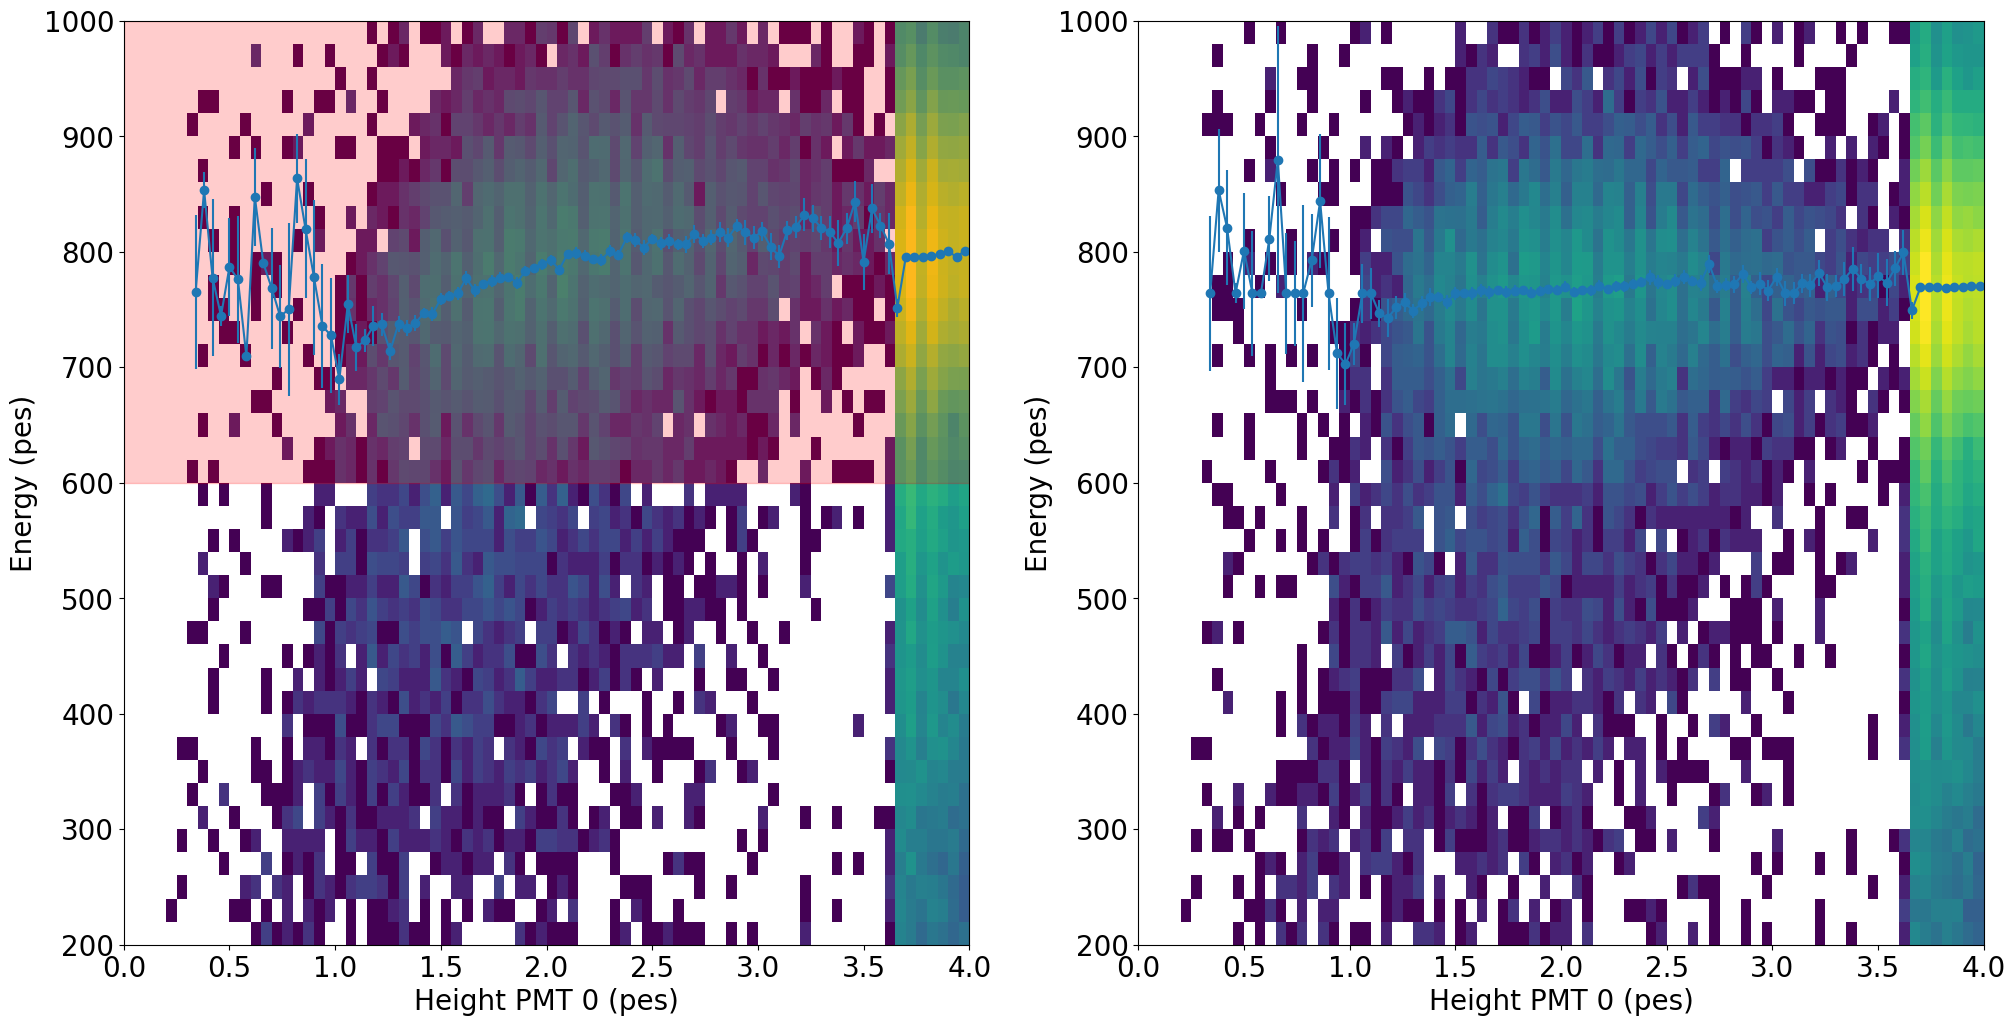

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins   = np.linspace(200, 1000, 41)
hbins     = np.linspace(0, 4., 81)

normed = False
var1   = 'h_pmt2'
var2   = 'energy'

sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 #& sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
#sel1 = sel1 & sel_r_1

h, x, y, *_ = axes[0].hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1], [hbins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());

hprof = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1], xrange=[hbins[0], hbins[-1]], yrange=erange, nbins=100)
axes[0].errorbar(hprof[0], hprof[1], yerr=hprof[2], marker='o')

xref  = 1.6
yref  = hprof[1][find_nearest_id(hprof[0], xref)]
hcorr = interpolate.interp1d(hprof[0], hprof[1]/yref, kind='nearest', fill_value='extrapolate')


hrange = [1.6, 1.7]
sel_h_1 = coref.in_range(data_1_s2[var1], *hrange)

axes[0].axhspan(*erange, alpha=0.2, color='r')
for ax in axes:
    ax.set_xlabel('Height PMT 0 (pes)')
    ax.set_ylabel('Energy (pes)')

h, x, y, *_ = axes[1].hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1] / hcorr(data_1_s2[var1][sel1]), [hbins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());

hprof_c = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1]/ hcorr(data_1_s2[var1][sel1]), xrange=[hbins[0], hbins[-1]], yrange=erange, nbins=100)
axes[1].errorbar(hprof_c[0], hprof_c[1], yerr=hprof_c[2], marker='o')


#### Ratio dependance

In [32]:
data_1_s2['pmt_0_ratio'] = data_1_s2['e_pmt0']/data_1_s2['energy']

<ErrorbarContainer object of 3 artists>

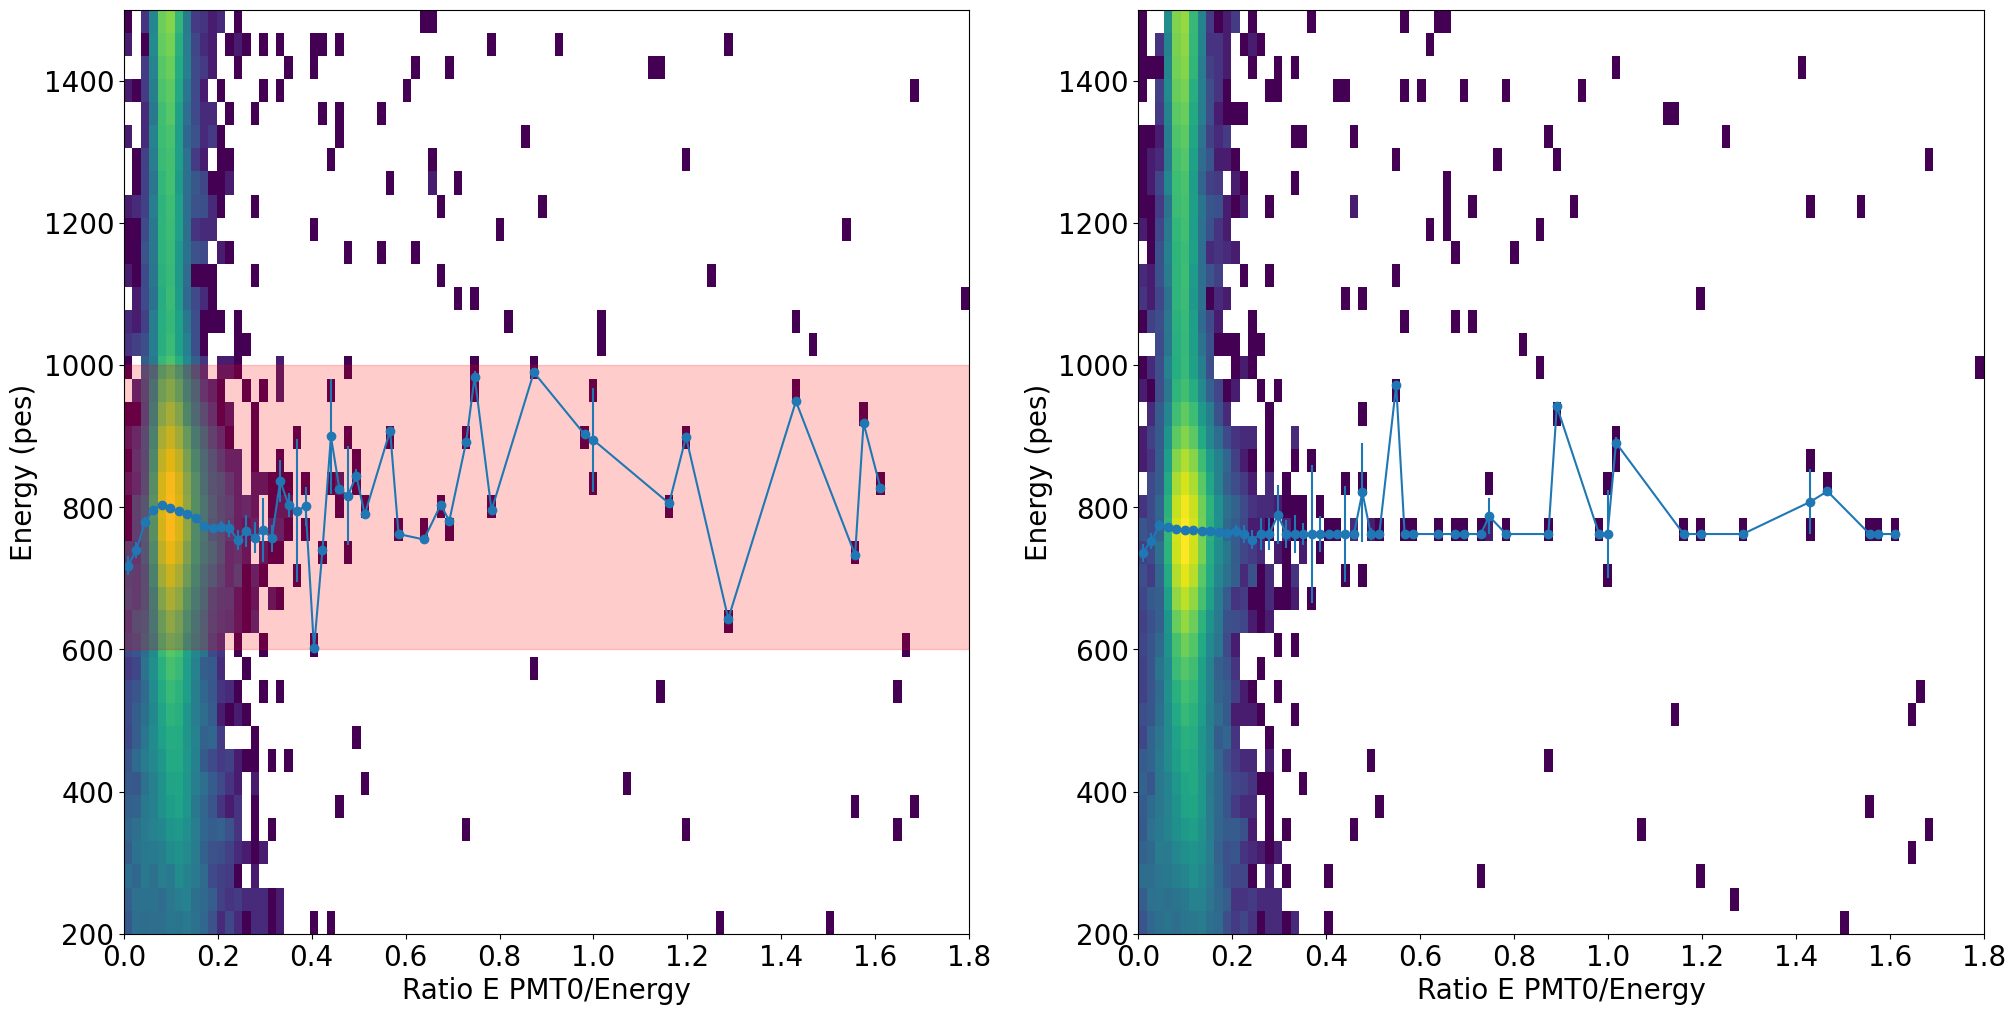

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins   = np.linspace(200, 1500, 41)
ratiobins     = np.linspace(0., 1.8, 101)
#ratiobins     = np.linspace(0., 0.3, 81)

normed = False
var1   = 'pmt_0_ratio'
var2   = 'energy'

sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 #& sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
#sel1 = sel1 & sel_r_1

h, x, y, *_ = axes[0].hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1], [ratiobins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());

ratioprof = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1], xrange=[ratiobins[0], ratiobins[-1]], yrange=erange, nbins=100)
axes[0].errorbar(ratioprof[0], ratioprof[1], yerr=ratioprof[2], marker='o')

xref  = 0.58
yref  = ratioprof[1][find_nearest_id(ratioprof[0], xref)]
ratiocorr = interpolate.interp1d(ratioprof[0], ratioprof[1]/yref, kind='nearest', fill_value='extrapolate')


ratiorange = [0.5, 0.7]
sel_ratio_1 = coref.in_range(data_1_s2[var1], *ratiorange)

axes[0].axhspan(*erange, alpha=0.2, color='r')
for ax in axes:
    ax.set_xlabel('Ratio E PMT0/Energy')
    ax.set_ylabel('Energy (pes)')

h, x, y, *_ = axes[1].hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1] / ratiocorr(data_1_s2[var1][sel1]), [ratiobins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());

ratioprof_c = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1]/ ratiocorr(data_1_s2[var1][sel1]), xrange=[ratiobins[0], ratiobins[-1]], yrange=erange, nbins=100)
axes[1].errorbar(ratioprof_c[0], ratioprof_c[1], yerr=ratioprof_c[2], marker='o')

#### Time dependance

In [36]:
data_1_s2['time'] = (data_1_s2['timestamp'] - data_1_s2['timestamp'].min())*8e-9/60

(array([2341., 1117.,  985., 2520., 2724., 3236., 3487., 3777., 3831.,
        3846., 3594., 3927., 4241., 3770., 3751., 3921., 3775., 3574.,
        3001., 2594., 3403., 3186., 3089., 4024., 3371., 3157., 4316.,
        4646., 3398., 3087., 3624., 3493., 3589., 3594., 4130., 3611.,
        3590., 3577., 3259., 3321., 3637., 3648., 3392., 2384., 2608.,
        2544., 2808., 3008., 3086., 3058., 3122., 3602., 3340., 2976.,
        2455., 2094., 2447., 2864., 2996., 3056., 3145., 3251., 3861.,
        3636., 3243., 2536., 2584., 3688., 3709., 3203., 2803., 3477.,
        3771., 3381., 3224., 3560., 3341., 3117., 2665., 3209.]),
 array([ 0.        ,  1.23508156,  2.47016312,  3.70524468,  4.94032625,
         6.17540781,  7.41048937,  8.64557093,  9.88065249, 11.11573405,
        12.35081562, 13.58589718, 14.82097874, 16.0560603 , 17.29114186,
        18.52622342, 19.76130499, 20.99638655, 22.23146811, 23.46654967,
        24.70163123, 25.93671279, 27.17179435, 28.40687592, 29.64195748,
 

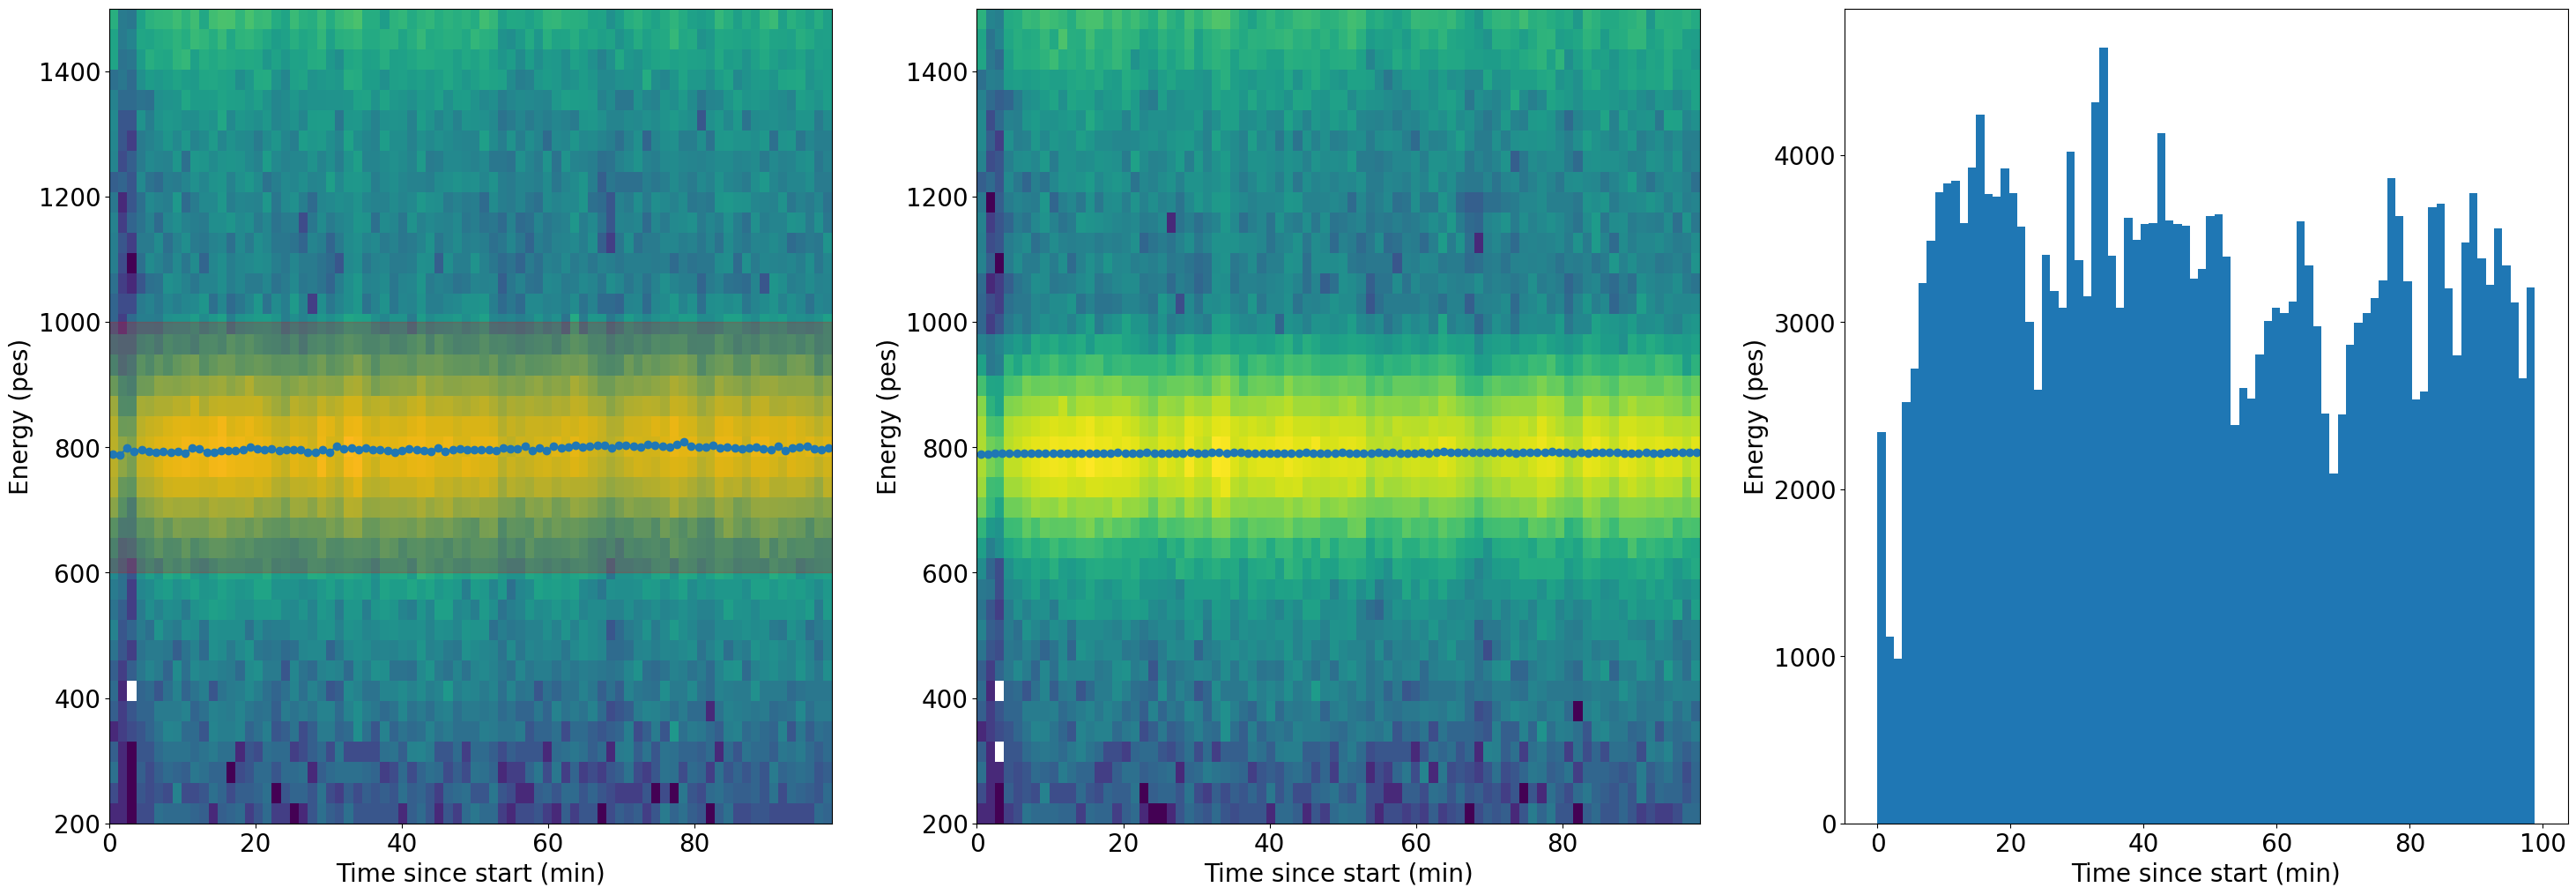

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(36, 12))

enebins   = np.linspace(200, 1500, 41)
tbins     = np.linspace(data_1_s2['time'].min(), data_1_s2['time'].max(), 81)
#tbins     = np.linspace(0., 0.3, 81)

normed = False
var1   = 'time'
var2   = 'energy'

sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 #& sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_t_1 
#sel1 = sel1 & sel_r_1

h, x, y, *_ = axes[0].hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1], [tbins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());

tprof = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1], xrange=[tbins[0], tbins[-1]], yrange=erange, nbins=100)
axes[0].errorbar(tprof[0], tprof[1], yerr=tprof[2], marker='o')

xref  = tbins[0]
yref  = tprof[1][find_nearest_id(tprof[0], xref)]
tcorr = interpolate.interp1d(tprof[0], tprof[1]/yref, kind='nearest', fill_value='extrapolate')


trange = [tbins[0], tbins[-1]]
sel_t_1 = coref.in_range(data_1_s2[var1], *trange)

axes[0].axhspan(*erange, alpha=0.2, color='r')
for ax in axes:
    ax.set_xlabel('Time since start (min)')
    ax.set_ylabel('Energy (pes)')

h, x, y, *_ = axes[1].hist2d(data_1_s2[var1][sel1], data_1_s2[var2][sel1] / tcorr(data_1_s2[var1][sel1]), [tbins, enebins],
               weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], 
               label=label_1, norm=mpl.colors.LogNorm());

tprof_c = fitf.profileX(data_1_s2[var1][sel1], data_1_s2[var2][sel1]/ tcorr(data_1_s2[var1][sel1]), xrange=[tbins[0], tbins[-1]], yrange=erange, nbins=100)
axes[1].errorbar(tprof_c[0], tprof_c[1], yerr=tprof_c[2], marker='o')

axes[2].hist(data_1_s2[var1][sel1], tbins)

E resolution =  22.72%


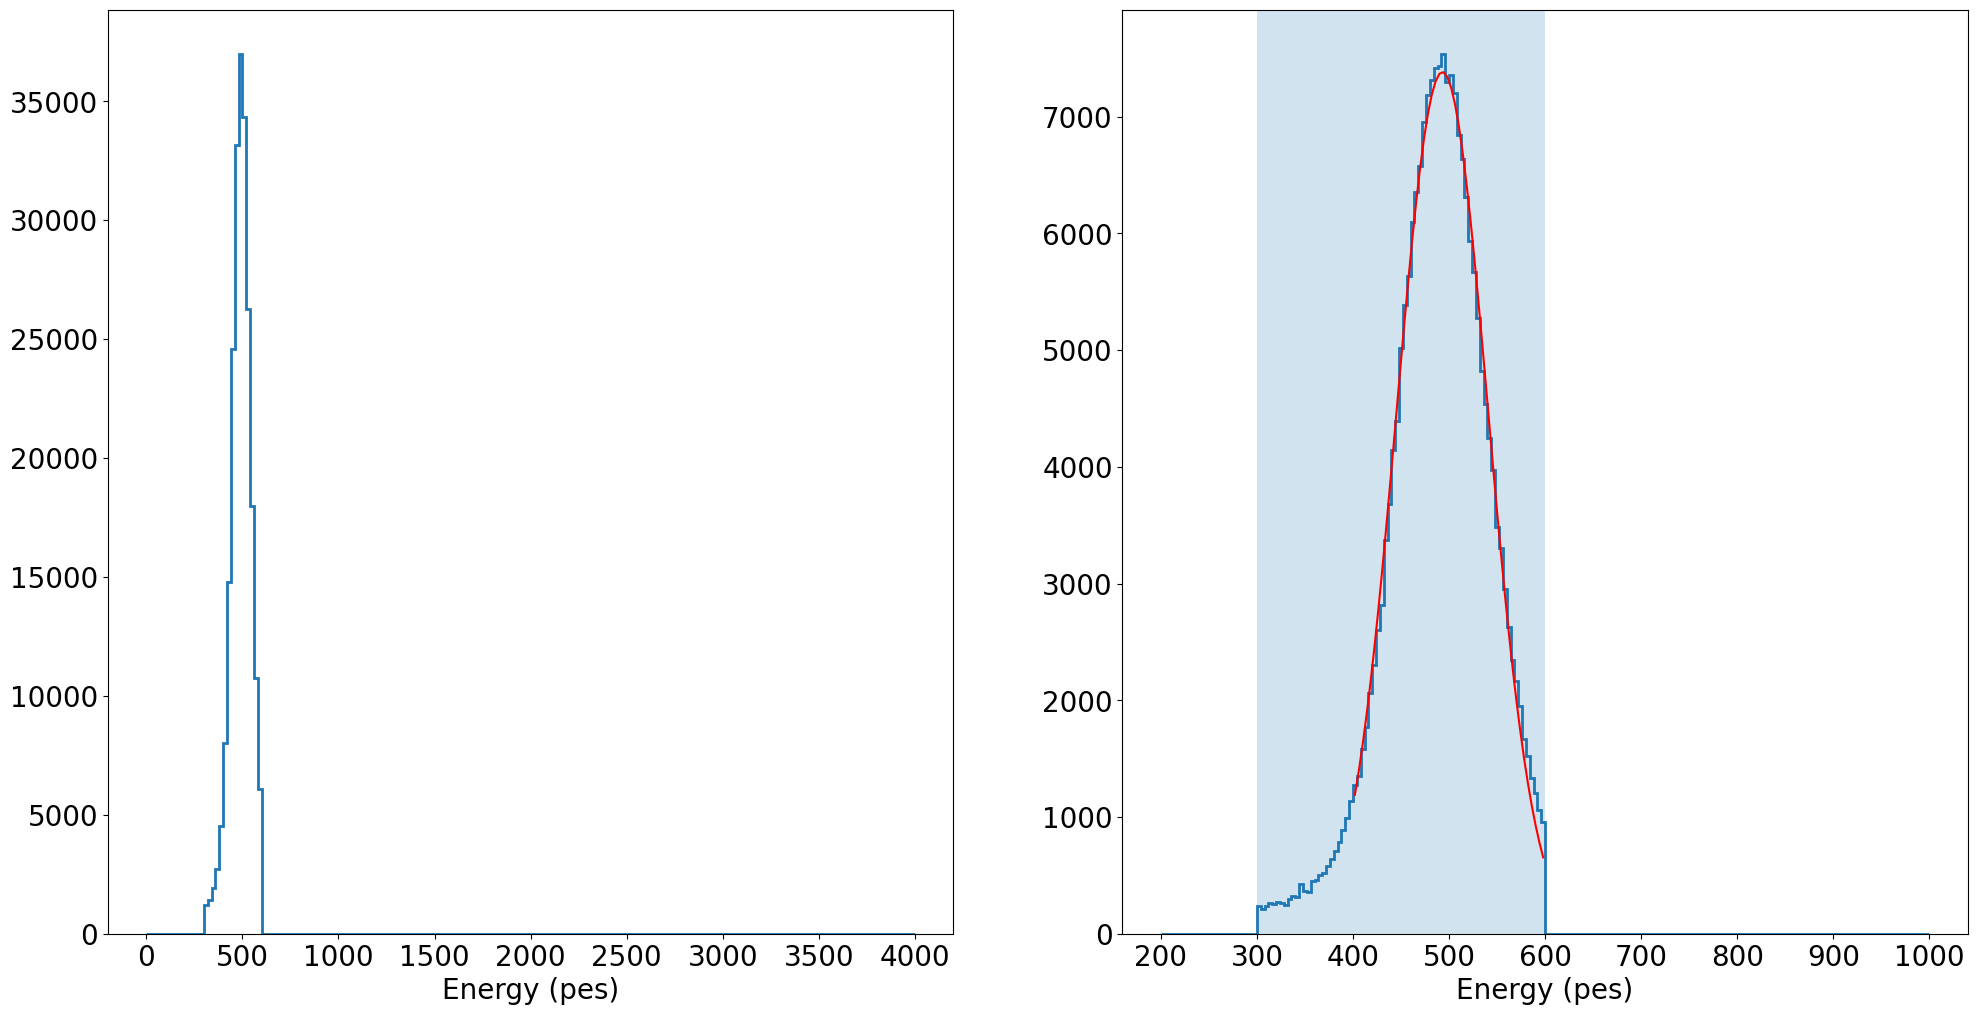

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins = np.linspace(0, 4000, 201)
#enebins = np.linspace(0000, 400, 251)
normed = False
var    = 'energy'

eref = 2.9
#eref = 5.9

sel1 = np.full(len(data_1_s2), True)

sel1 = sel1 & sel_e_1 
#sel1 = sel1 & sel_w_1 
sel1 = sel1 & sel_ratio_1 
#sel1 = sel1 & sel_r_1
#sel1 = sel1 & sel_h_1
#wcorr_factor     = 1 / wcorr(data_1_s2['width'][sel1])
#hcorr_factor     = 1 #/ hcorr(data_1_s2['h_pmt0'][sel1])
#tcorr_factor     = 1 #/ tcorr(data_1_s2['time'][sel1])
#ratiocorr_factor = 1 #/ ratiocorr(data_1_s2['pmt_0_ratio'][sel1])
#wcorr_factor = 1 / wcorr(data_1_s2['width'][sel1])
corr = 1
#corr *= wcorr_factor
#corr *= hcorr_factor
#corr *= ratiocorr_factor
#corr *= tcorr_factor


y,x, *_ = axes[0].hist(data_1_s2[var][sel1] * corr, enebins, histtype='step', 
         lw=2, weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], label=label_1);
x = coref.shift_to_bin_centers(x)
escale_1 = x[y.argmax()]/eref

enebins = np.linspace(200, 1000, 201)
yd, xd, *_ = axes[1].hist(data_1_s2[var][sel1] * corr, enebins, histtype='step', 
         lw=2, weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], label=label_1);
xd = coref.shift_to_bin_centers(xd)

for ax in axes:
    #ax.set_yscale('log')
    pass

axes[0].set_xlabel('Energy (pes)')
axes[1].set_xlabel('Energy (pes)')


erange = [300, 600]
axes[1].axvspan(*erange, alpha=0.2)
sel_e_1 = coref.in_range(data_1_s2[var], *erange)

efit = [400, 600]
sel_f = coref.in_range(xd, *efit)

mod  = GaussianModel()
pars = mod.guess(yd[sel_f], x=xd[sel_f])
out = mod.fit(yd[sel_f], pars, x=xd[sel_f])

axes[1].plot(xd[sel_f], out.best_fit, '-', c='r')

result =  out.result.params
mu     = [result['center'].value, result['center'].stderr]
sigma  = [result['sigma' ].value, result['sigma' ].stderr]
reso   = sigma[0]/mu[0] * 235
print(f'E resolution =  {reso:.2f}%')
#print(f'Intrinsic resolution = {get_intrinsic_resolution(eref*1000, fano, wi, mu[0], pmt_sigma)}%')

E resolution =  22.87%
Intrinsic resolution = 14.45795493276886%


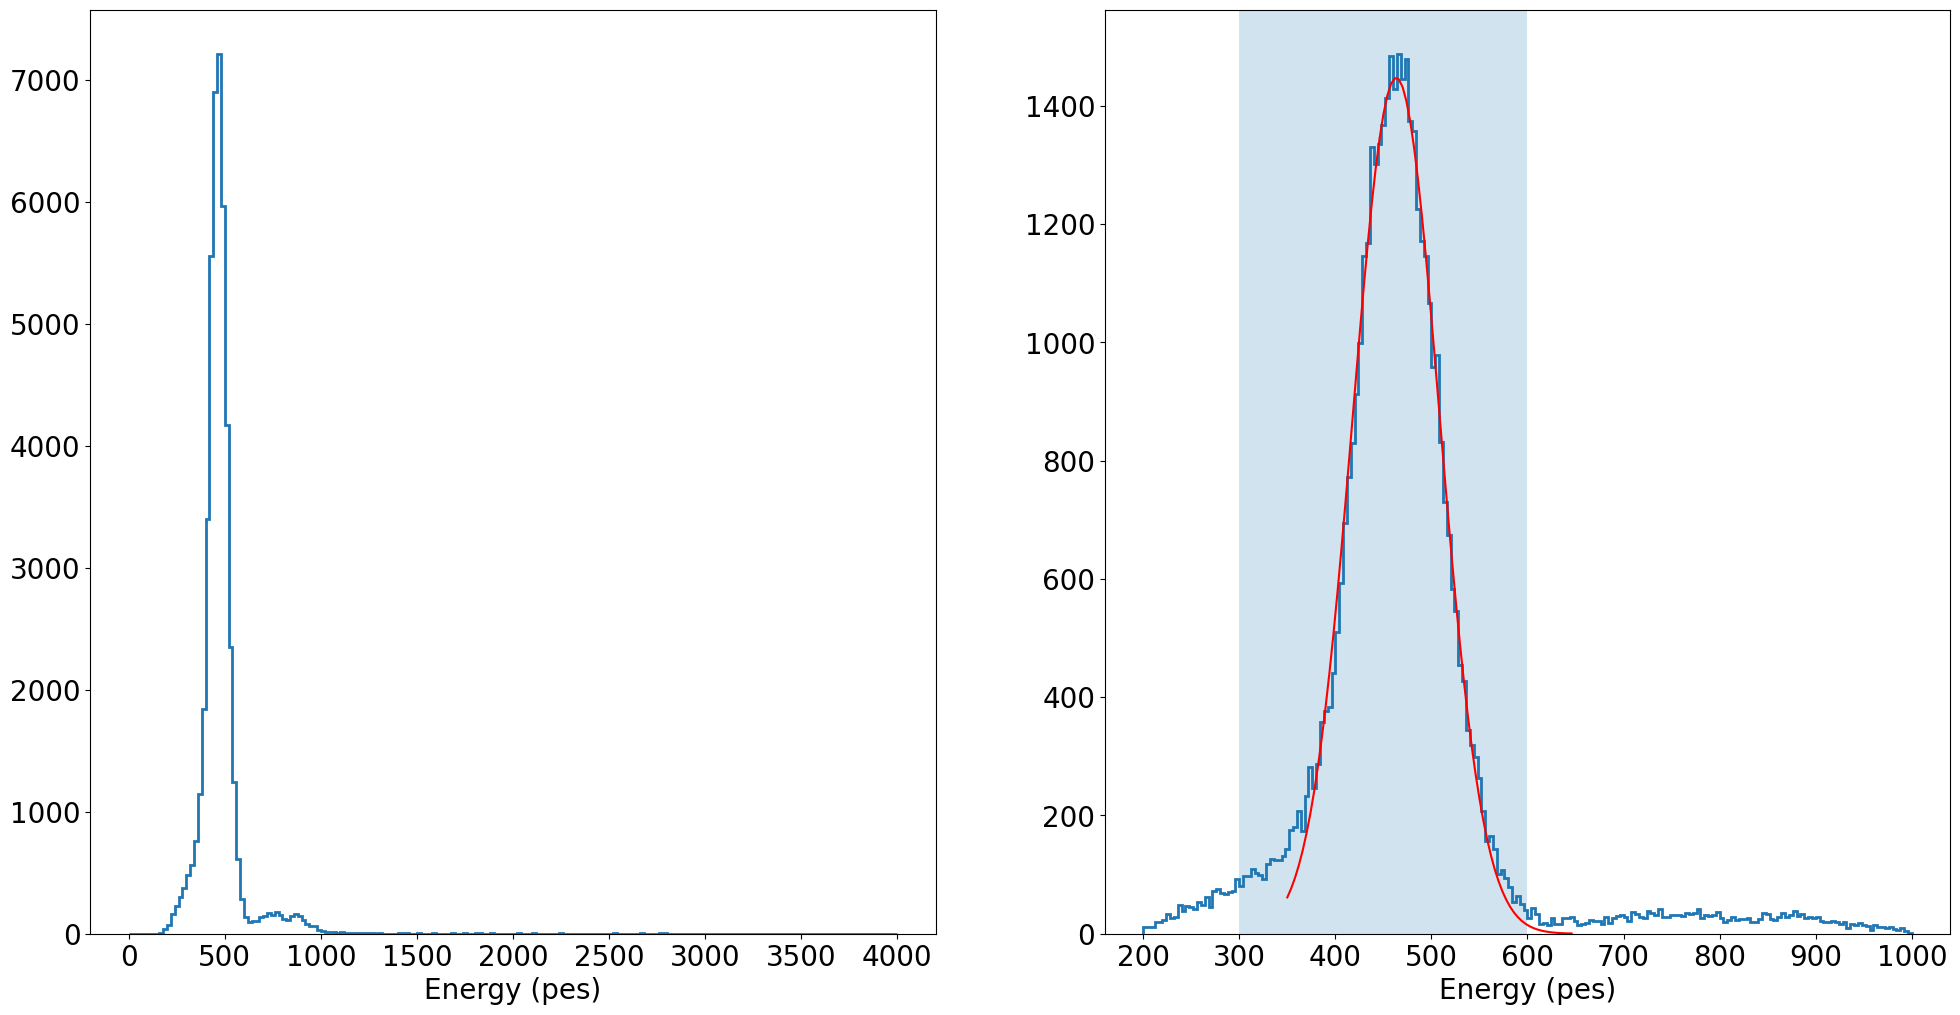

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins = np.linspace(0, 4000, 201)
#enebins = np.linspace(0000, 400, 251)
normed = False
var    = 'energy'

eref = 2.9
#eref = 5.9

sel1 = np.full(len(data_1_s2), True)

#sel1 = sel1 #& sel_e_1 
#sel1 = sel1 & sel_w_1 
#sel1 = sel1 & sel_ratio_1 
#sel1 = sel1 & sel_r_1
#sel1 = sel1 & sel_h_1
wcorr_factor     = 1 / wcorr(data_1_s2['width'][sel1])
hcorr_factor     = 1 / hcorr(data_1_s2['h_pmt0'][sel1])
tcorr_factor     = 1 / tcorr(data_1_s2['time'][sel1])
ratiocorr_factor = 1 / ratiocorr(data_1_s2['pmt_0_ratio'][sel1])
#wcorr_factor = 1 / wcorr(data_1_s2['width'][sel1])
corr = 1
corr *= wcorr_factor
#corr *= hcorr_factor
#corr *= ratiocorr_factor
#corr *= tcorr_factor


y,x, *_ = axes[0].hist(data_1_s2[var][sel1] * corr, enebins, histtype='step', 
         lw=2, weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], label=label_1);
x = coref.shift_to_bin_centers(x)
escale_1 = x[y.argmax()]/eref

enebins = np.linspace(200, 1000, 201)
yd, xd, *_ = axes[1].hist(data_1_s2[var][sel1] * corr, enebins, histtype='step', 
         lw=2, weights=weights_1_s2[sel1]/len(data_1_s2) if normed else weights_1_s2[sel1], label=label_1);
xd = coref.shift_to_bin_centers(xd)

for ax in axes:
    #ax.set_yscale('log')
    pass

axes[0].set_xlabel('Energy (pes)')
axes[1].set_xlabel('Energy (pes)')


erange = [300, 600]
axes[1].axvspan(*erange, alpha=0.2)
sel_e_1 = coref.in_range(data_1_s2[var], *erange)

efit = [350, 650]
sel_f = coref.in_range(xd, *efit)

mod  = GaussianModel()
pars = mod.guess(yd[sel_f], x=xd[sel_f])
out = mod.fit(yd[sel_f], pars, x=xd[sel_f])

axes[1].plot(xd[sel_f], out.best_fit, '-', c='r')

result =  out.result.params
mu     = [result['center'].value, result['center'].stderr]
sigma  = [result['sigma' ].value, result['sigma' ].stderr]
reso   = sigma[0]/mu[0] * 235
print(f'E resolution =  {reso:.2f}%')
print(f'Intrinsic resolution = {get_intrinsic_resolution(eref*1000, fano, wi, mu[0], pmt_sigma)}%')

E resolution =  28.16%
Intrinsic resolution = 14.949051720956648%


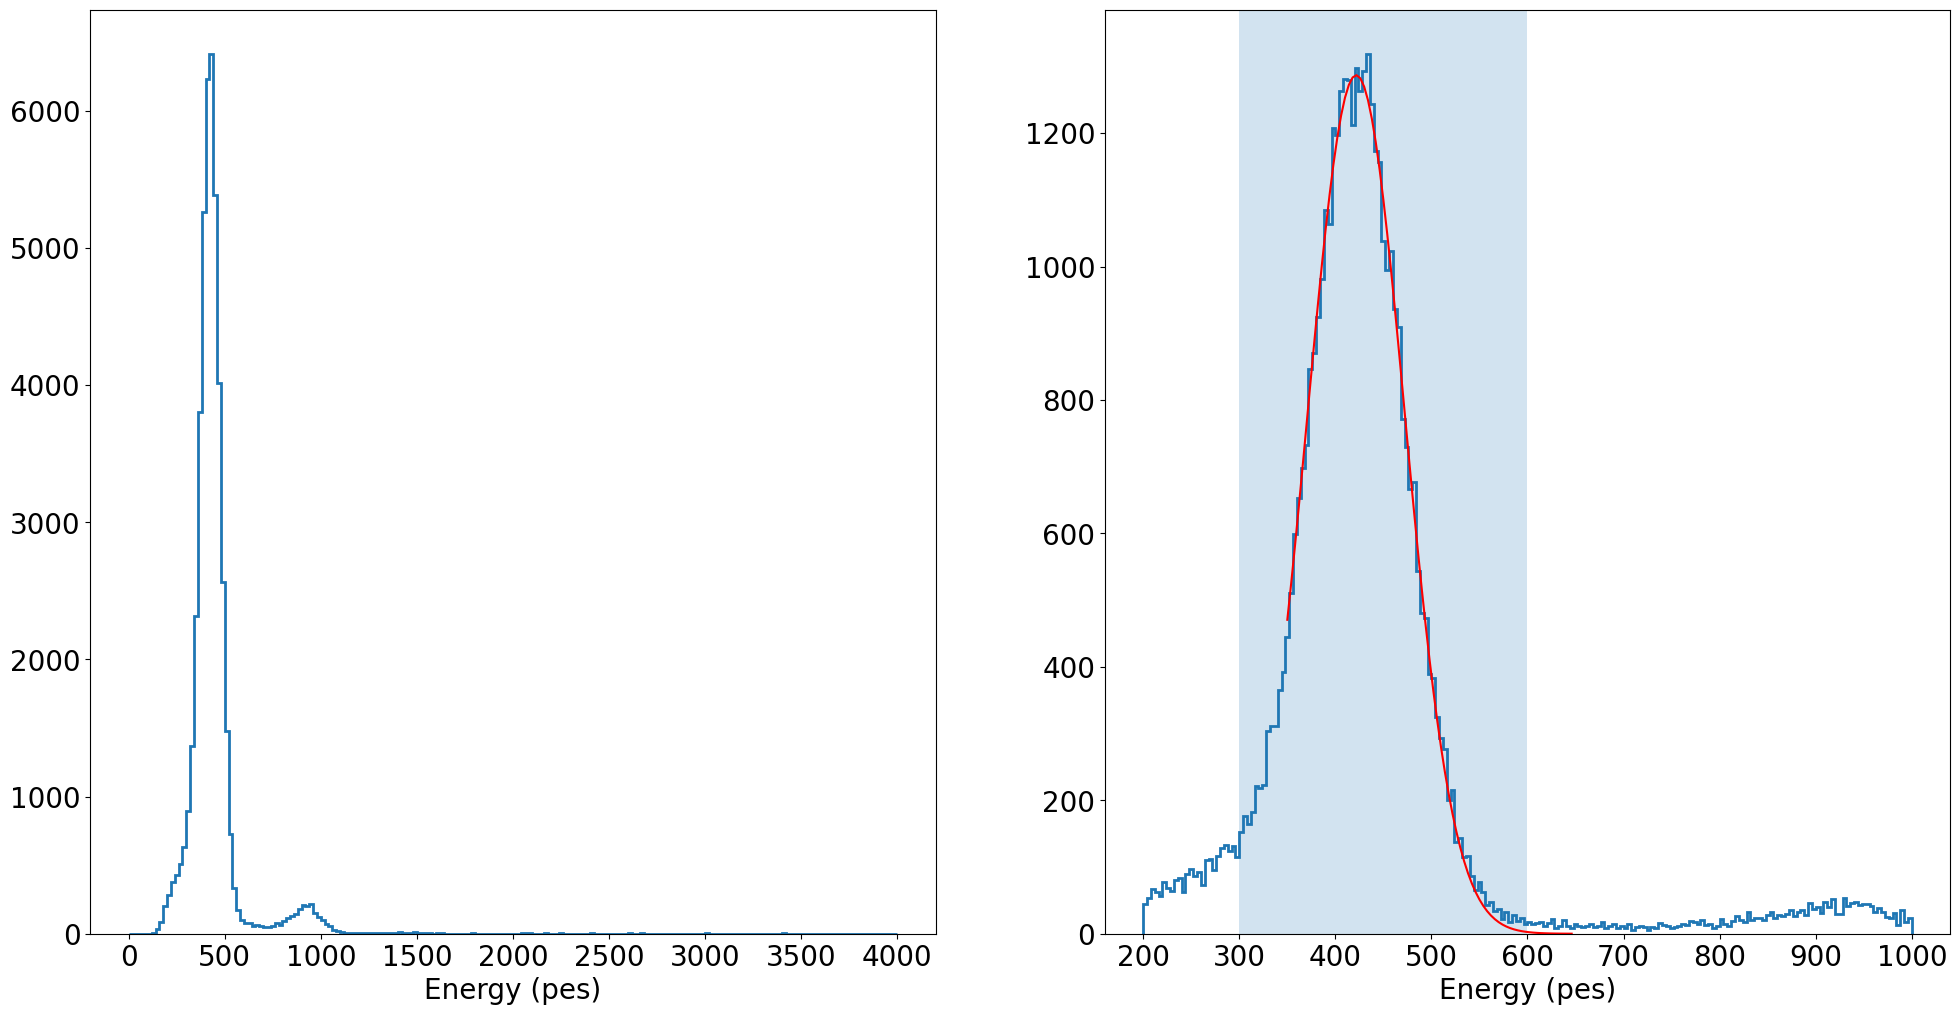

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

enebins = np.linspace(0, 4000, 201)
#enebins = np.linspace(0000, 400, 251)
normed = False
var    = 'energy'

eref = 2.9
#eref = 5.9

y,x, *_ = axes[0].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);
x = coref.shift_to_bin_centers(x)
escale_1 = x[y.argmax()]/eref

enebins = np.linspace(200, 1000, 201)
yd, xd, *_ = axes[1].hist(data_1_s2[var], enebins, histtype='step', 
         lw=2, weights=weights_1_s2/len(data_1_s2) if normed else weights_1_s2, label=label_1);
xd = coref.shift_to_bin_centers(xd)

for ax in axes:
    #ax.set_yscale('log')
    pass

axes[0].set_xlabel('Energy (pes)')
axes[1].set_xlabel('Energy (pes)')


erange = [300, 600]
axes[1].axvspan(*erange, alpha=0.2)
sel_e_1 = coref.in_range(data_1_s2[var], *erange)

efit = [350, 650]
sel_f = coref.in_range(xd, *efit)

mod  = GaussianModel()
pars = mod.guess(yd[sel_f], x=xd[sel_f])
out = mod.fit(yd[sel_f], pars, x=xd[sel_f])

axes[1].plot(xd[sel_f], out.best_fit, '-', c='r')

result =  out.result.params
mu     = [result['center'].value, result['center'].stderr]
sigma  = [result['sigma' ].value, result['sigma' ].stderr]
reso   = sigma[0]/mu[0] * 235
print(f'E resolution =  {reso:.2f}%')
print(f'Intrinsic resolution = {get_intrinsic_resolution(eref*1000, fano, wi, mu[0], pmt_sigma)}%')

In [27]:
E = 8.5
p = 6.2

print((81*E/p - 47)*p)

397.1


In [30]:
400*5900/22

107272.72727272728

In [31]:
500/(400*5900/22)

0.004661016949152542

In [6]:
def el_yield(p, kv):
    return (81*kv/p - 47)*p

el_yield(6.2, 9.5)

478.09999999999997

In [3]:
el_yield(8.4, 11.5)

536.6999999999999

In [11]:
db.DataPMT('gap', 1).adc_to_pes

0    37.01
1    18.90
2    32.46
3    29.27
4    31.68
5    42.64
6    34.54
Name: adc_to_pes, dtype: float64

In [16]:
adc = db.DataPMT('gap', 1).adc_to_pes
print(adc/adc[0] * 120)

0    120.000000
1     61.280735
2    105.247230
3     94.904080
4    102.718184
5    138.254526
6    111.991354
Name: adc_to_pes, dtype: float64


In [13]:
60/18

3.3333333333333335

In [15]:
120/37

3.2432432432432434

In [71]:
0.649*np.sqrt(1200)

22.48201948224403

In [72]:
22/1.43

15.384615384615385